In [5]:
import os, tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mlguess.regression_uq import compute_results, compute_coverage, rmse_crps_skill_scores, calculate_skill_score, plot_uncertainties
from mlguess.keras.layers import DenseNormalGamma
from mlguess.keras.losses import EvidentialRegressionLoss
from mlguess.pit import pit_deviation_skill_score
from matplotlib.colors import LogNorm
from keras.models import load_model
from bridgescaler import load_scaler
from scipy.ndimage import gaussian_filter
from sklearn.metrics import r2_score
%matplotlib inline

In [6]:
output_cols = [
    'friction_velocity:surface:m_s-1',
    'kinematic_sensible_heat_flux:surface:K_m_s-1',
    'kinematic_latent_heat_flux:surface:g_kg-1_m_s-1'
]

# Model Sensitivity

In [7]:
mod = load_model("/glade/work/schreck/repos/miles-guess/apr24/results/sensible_heat_evidential/models/best.h5", 
                 custom_objects={"DenseNormalGamma":DenseNormalGamma, "EvidentialRegressionLoss":EvidentialRegressionLoss}, compile=False)
in_scaler = load_scaler("/glade/work/schreck/repos/miles-guess/apr24/results/sensible_heat_evidential/scalers/best_input.json")
out_scaler = load_scaler("/glade/work/schreck/repos/miles-guess/apr24/results/sensible_heat_evidential/scalers/best_output.json")

2024-09-08 18:39:56.202031: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glade/u/apps/casper/23.10/spack/opt/spack/openmpi/4.1.6/oneapi/2023.2.1/dgcv/lib:/glade/u/apps/common/23.08/spack/opt/spack/cuda/12.2.1/lib64:/glade/u/apps/common/23.08/spack/opt/spack/cuda/12.2.1/nvvm/lib64:/glade/u/apps/common/23.08/spack/opt/spack/cuda/12.2.1/extras/CUPTI/lib64:/glade/u/apps/common/23.08/spack/opt/spack/cuda/12.2.1/extras/Debugger/lib64:/glade/u/apps/common/23.08/spack/opt/spack/intel-oneapi-compilers/2023.2.1/compiler/2023.2.1/linux/lib:/glade/u/apps/common/23.08/spack/opt/spack/intel-oneapi-compilers/2023.2.1/compiler/2023.2.1/linux/lib/x64:/glade/u/apps/common/23.08/spack/opt/spack/intel-oneapi-compilers/2023.2.1/compiler/2023.2.1/linux/lib/oclfpga/host/linux64/lib:/glade/u/apps/common/23.08/spack/opt/spac

wind_speed:10_m:m_s-1
potential_temperature_skin_change:10_m:K_m-1
bulk_richardson:10_m:None
 mixing_ratio_skin_change:2_m:g_kg-1_m-1

In [ ]:
f_sh_train = pd.read_csv(f"{data_path}/results/sensible_heat_evidential/evaluate/test.csv")

In [4]:
n_rows = 100
perturb_vals = pd.DataFrame({"wind_speed:10_m:m_s-1": np.ones(n_rows) * 4, 
                "potential_temperature_skin_change:10_m:K_m-1": np.linspace(-5, 5, n_rows),
                "bulk_richardson:10_m:None": np.zeros(n_rows),
                "mixing_ratio_skin_change:2_m:g_kg-1_m-1": np.zeros(n_rows)})

In [107]:
perturb_preds = mod.predict(perturb_vals.values)


4/4 [==============================] - 0s 6ms/step


In [114]:
perturb_vals_real = in_scaler.inverse_transform(perturb_vals)

In [192]:
def bulk_richardson(wind_speed, temp_grad, ref_temp=293):
    g = 9.81
    return g / ref_temp * temp_grad / np.maximum(wind_speed ** 2, 0.01)

In [297]:
n_spots = 100
v_t = 293.0
wind_range = np.linspace(in_scaler.quantiles_[0,0], in_scaler.quantiles_[-1,0], n_spots)
temp_grad_range = np.linspace(in_scaler.quantiles_[0,1], in_scaler.quantiles_[-1,1], n_spots)
temp_grid, wind_grid = np.meshgrid(temp_grad_range, wind_range)
br_grid = bulk_richardson(wind_grid.ravel(), temp_grid.ravel(), v_t)
q_ref = -0.0227628
grid_df = pd.DataFrame({"wind_speed:10_m:m_s-1": wind_grid.ravel(), 
                "potential_temperature_skin_change:10_m:K_m-1": temp_grid.ravel(),
                "bulk_richardson:10_m:None": br_grid,
                "mixing_ratio_skin_change:2_m:g_kg-1_m-1": np.ones(n_spots * n_spots) * q_ref})
grid_norm = in_scaler.transform(grid_df)

In [298]:
grid_preds = mod.predict(grid_norm, batch_size=1000)

10/10 [==============================] - 1s 58ms/step


In [299]:
freq_grid = np.histogram2d(f_sh_train["potential_temperature_skin_change:10_m:K_m-1"], f_sh["wind_speed:10_m:m_s-1"],  
                           bins=(temp_grad_range[::2], wind_range[::2], ), density=False)

In [215]:
freq_grid[0].shape

(99, 99)

/glade/derecho/scratch/dgagne/tmp/ipykernel_228185/1668177226.py:9: UserWarning: Log scale: values of z <= 0 have been masked
  fc = ax.contour(freq_grid[1][:-1], freq_grid[2][:-1], gaussian_filter(freq_grid[0].T, 1), np.array([1, 10, 100, 1000, 10000]), norm=LogNorm(), cmap="Greys")


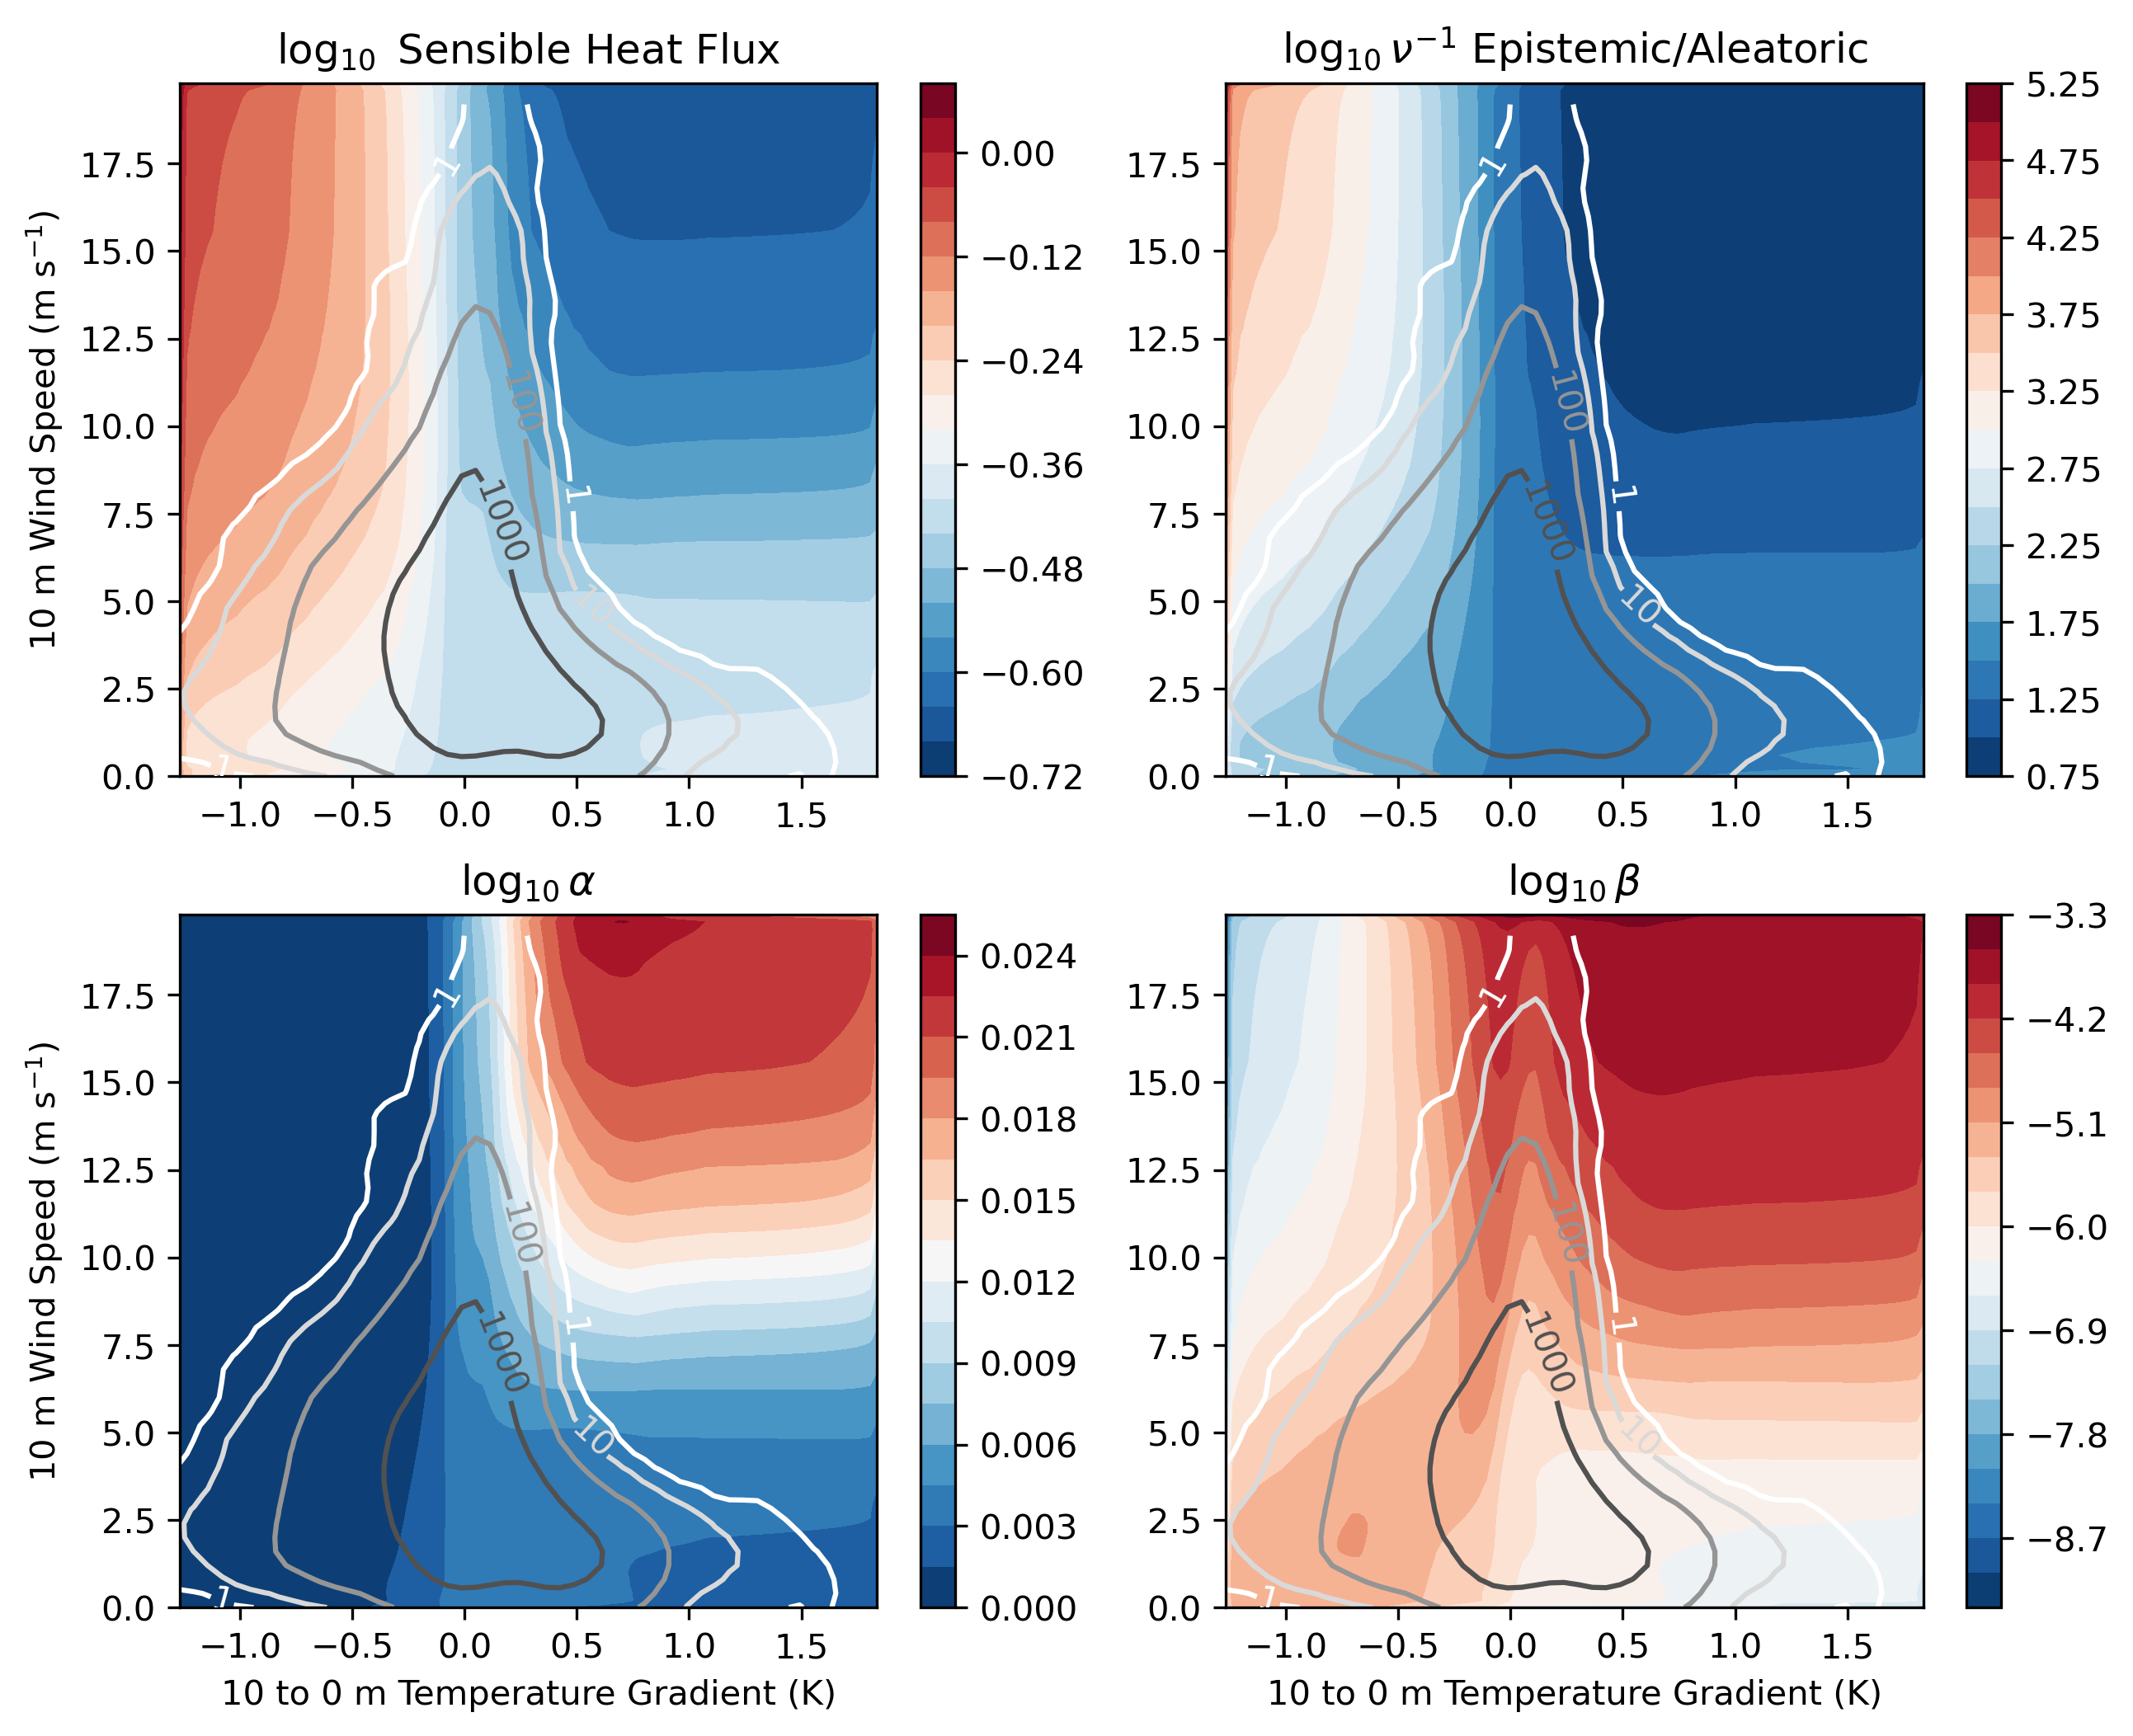

In [310]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
ax_titles = ["$\\log_{10}$ Sensible Heat Flux", 
             "$\\log_{10} \\nu^{-1}$ Epistemic/Aleatoric", "$\log_{10} \\alpha$", "$\\log_{10} \\beta$"]
for a, ax in enumerate(axes.ravel()):
    if a == 1:
        cf = ax.contourf(temp_grad_range, wind_range,  np.log10(1 / grid_preds[:, a]).reshape(100,100), 20, cmap="RdBu_r")
    else:
        cf = ax.contourf(temp_grad_range, wind_range, np.log10(grid_preds[:, a]).reshape(100,100), 20, cmap="RdBu_r")
    fc = ax.contour(freq_grid[1][:-1], freq_grid[2][:-1], gaussian_filter(freq_grid[0].T, 1), np.array([1, 10, 100, 1000, 10000]), norm=LogNorm(), cmap="Greys")
    plt.clabel(fc)
    plt.colorbar(cf)
    ax.set_xticks(np.arange(-1.0, 2.0, 0.5))
    if a % 2 == 0:
        ax.set_ylabel("10 m Wind Speed (m s$^{-1}$)")
    if a > 1:
        ax.set_xlabel("10 to 0 m Temperature Gradient (K)")

    ax.set_title(ax_titles[a])
plt.savefig("figures/sensible_heat_uncertainty_surfaces.pdf", bbox_inches="tight")
plt.savefig("figures/sensible_heat_uncertainty_surfaces.png", bbox_inches="tight")

/glade/derecho/scratch/dgagne/tmp/ipykernel_228185/4152185012.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  fc = ax.contour(freq_grid[1][:-1], freq_grid[2][:-1], gaussian_filter(freq_grid[0].T, 1), np.array([1, 10, 100, 1000, 10000]), norm=LogNorm(), cmap="Greys")


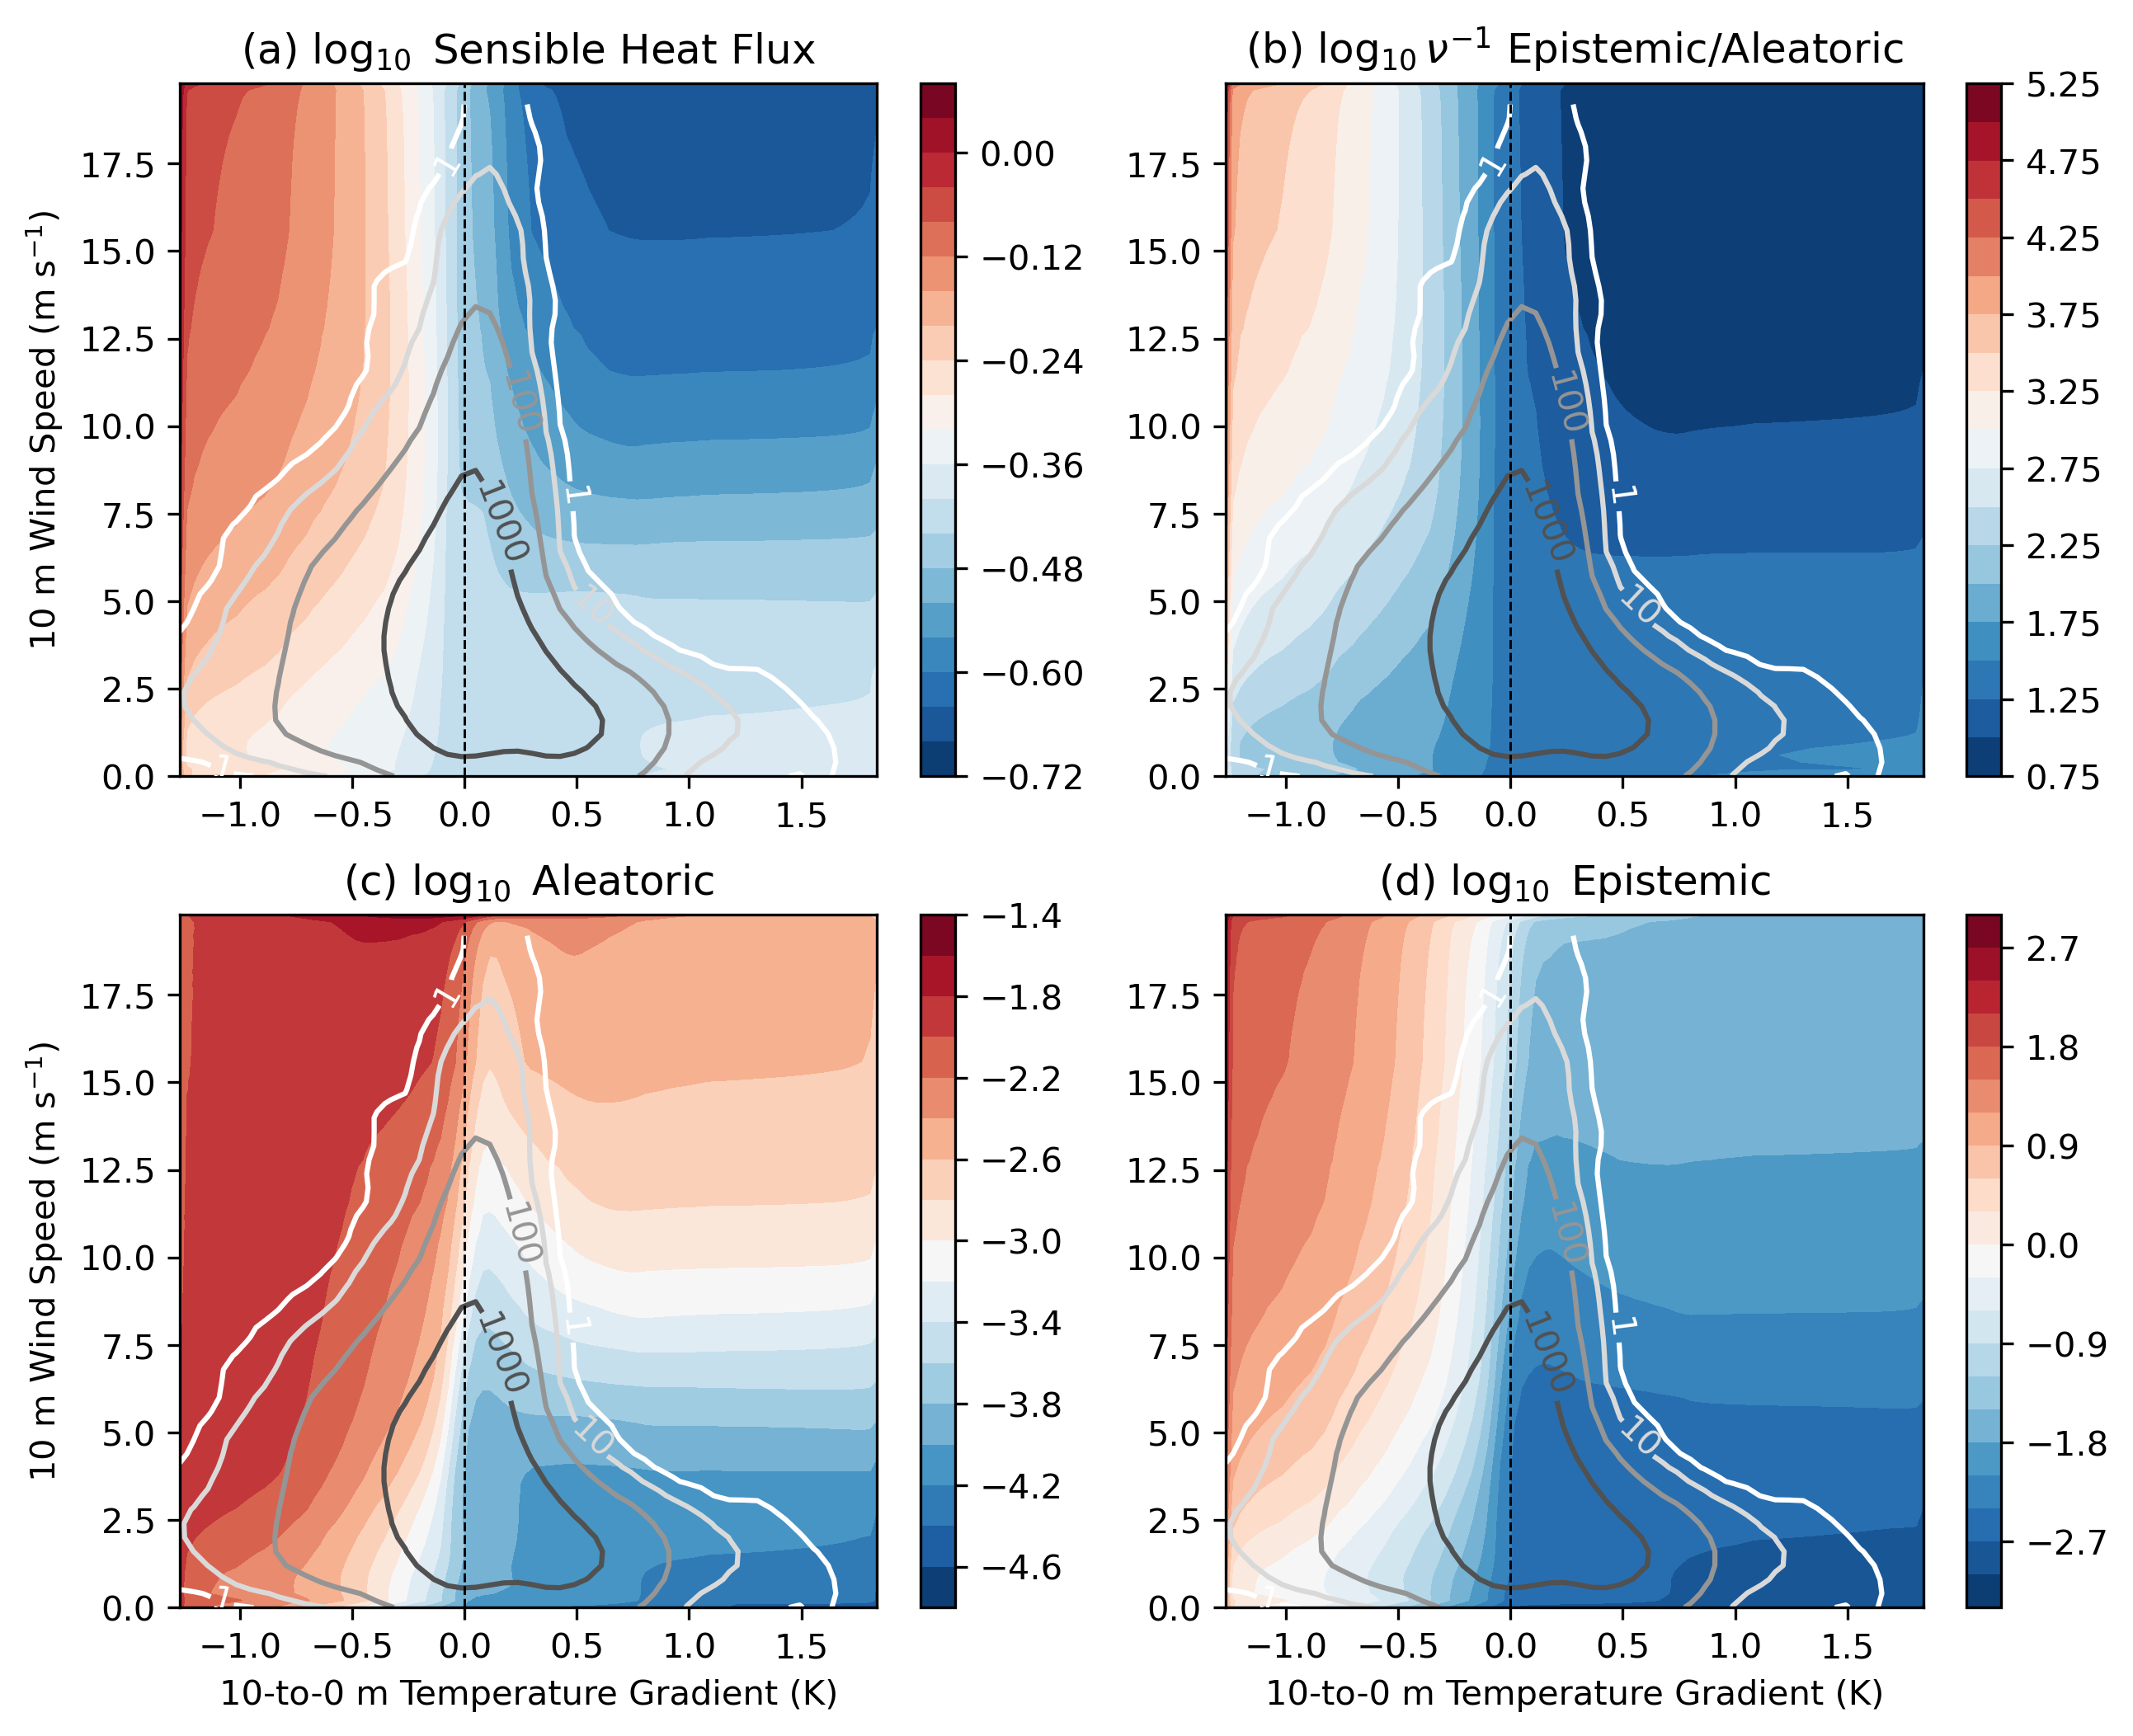

In [324]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
ax_titles = ["(a) $\\log_{10}$ Sensible Heat Flux", 
             "(b) $\\log_{10} \\nu^{-1}$ Epistemic/Aleatoric", 
             "(c) $\\log_{10}$ Aleatoric", "(d) $\\log_{10}$ Epistemic"]
for a, ax in enumerate(axes.ravel()):
    if a == 1:
        cf = ax.contourf(temp_grad_range, wind_range, np.log10(1 / grid_preds[:, a]).reshape(100,100), 20, cmap="RdBu_r")
    elif a == 0:
        cf = ax.contourf(temp_grad_range, wind_range,  np.log10(grid_preds[:, a]).reshape(100,100), 20, cmap="RdBu_r")
    elif a == 2:
        cf = ax.contourf(temp_grad_range, wind_range, np.log10(grid_preds[:, 3] / (grid_preds[:, 2] - 1)).reshape(100,100), 20, cmap="RdBu_r")
    elif a == 3:
        cf = ax.contourf(temp_grad_range, wind_range, np.log10(grid_preds[:, 3] /(grid_preds[:, 1] * (grid_preds[:, 2] - 1))).reshape(100,100), 20, cmap="RdBu_r")
    fc = ax.contour(freq_grid[1][:-1], freq_grid[2][:-1], gaussian_filter(freq_grid[0].T, 1), np.array([1, 10, 100, 1000, 10000]), norm=LogNorm(), cmap="Greys")
    plt.clabel(fc)
    plt.colorbar(cf)
    ax.set_xticks(np.arange(-1.0, 2.0, 0.5))
    if a % 2 == 0:
        ax.set_ylabel("10 m Wind Speed (m s$^{-1}$)")
    if a > 1:
        ax.set_xlabel("10-to-0 m Temperature Gradient (K)")
    ax.set_title(ax_titles[a])
    ax.plot(np.zeros_like(wind_range), wind_range, 'k--', lw=0.7)
plt.savefig("figures/sensible_heat_uncertainty_total.pdf", bbox_inches="tight")
plt.savefig("figures/sensible_heat_uncertainty_total.png", bbox_inches="tight")

/glade/derecho/scratch/dgagne/tmp/ipykernel_228185/746266569.py:13: UserWarning: Log scale: values of z <= 0 have been masked
  fc = ax.contour(freq_grid[1][:-1], freq_grid[2][:-1], gaussian_filter(freq_grid[0].T, 1), np.array([1, 10, 100, 1000, 10000]), norm=LogNorm(), cmap="Greys")


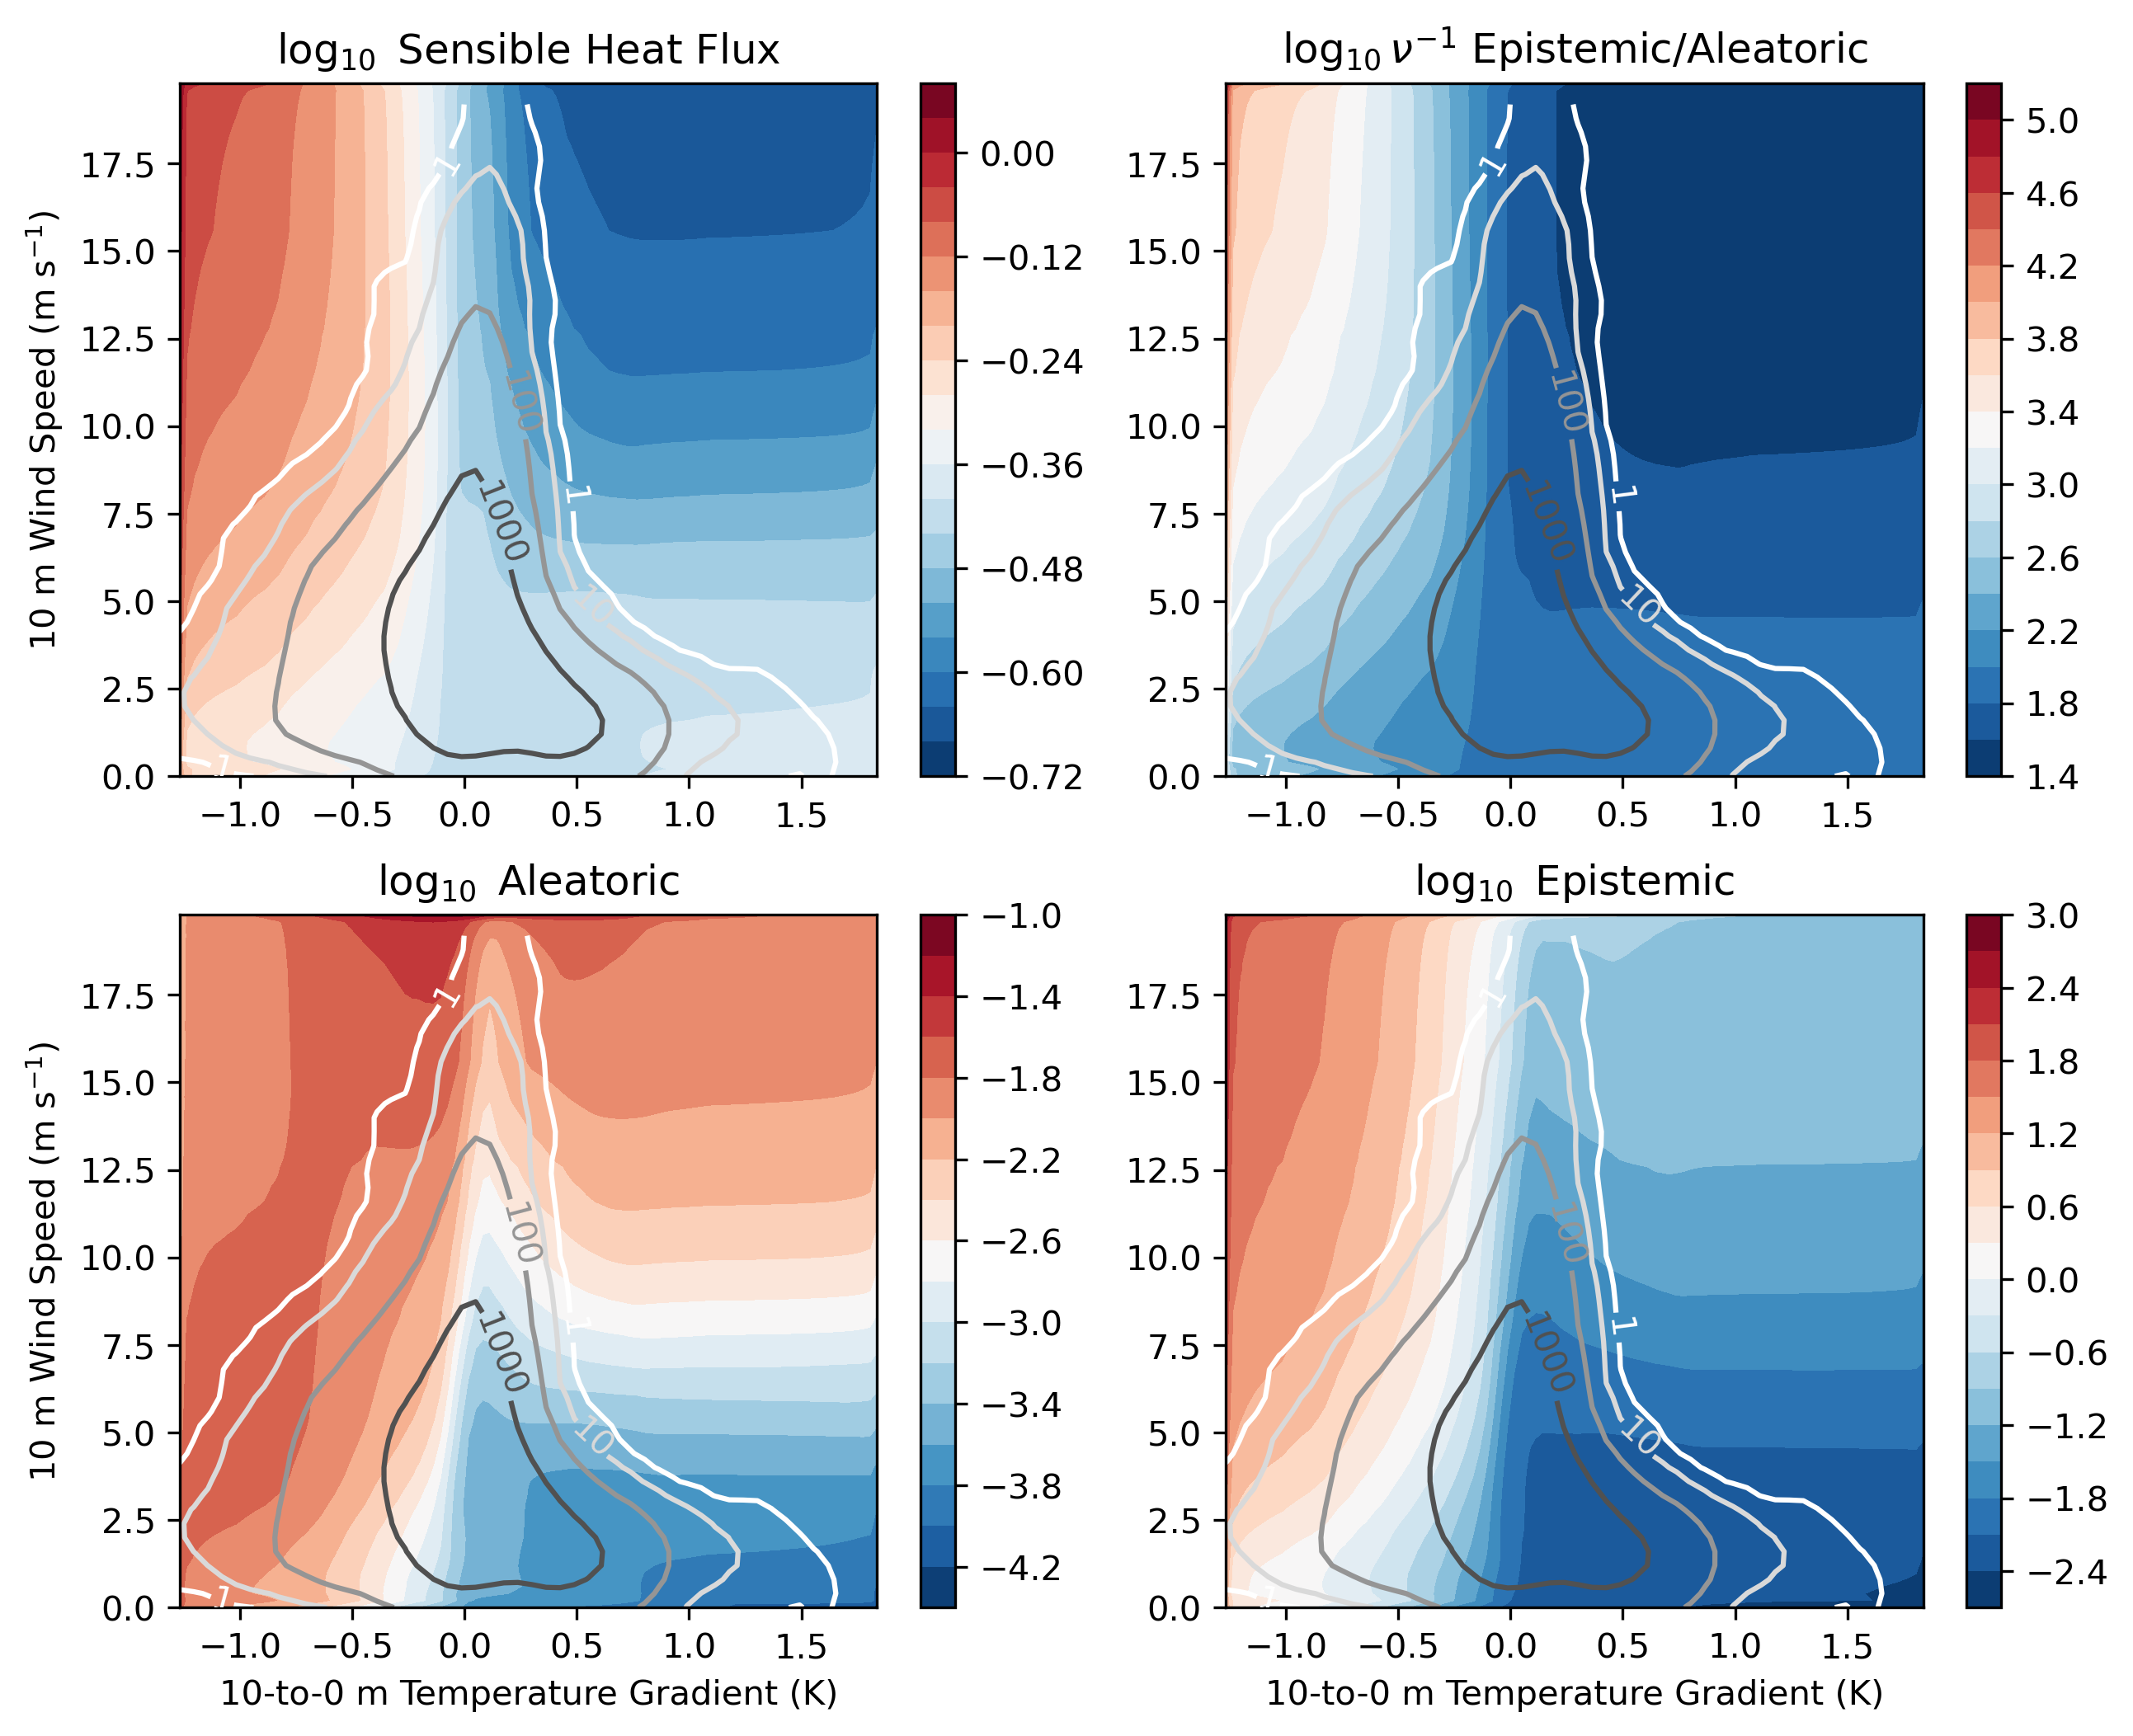

In [317]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
ax_titles = ["$\\log_{10}$ Sensible Heat Flux", 
             "$\\log_{10} \\nu^{-1}$ Epistemic/Aleatoric", "$\\log_{10}$ Aleatoric", "$\\log_{10}$ Epistemic"]
for a, ax in enumerate(axes.ravel()):
    if a == 1:
        cf = ax.contourf(temp_grad_range, wind_range, np.log10(1 / (grid_preds[:, 0] * grid_preds[:, a])).reshape(100,100), 20, cmap="RdBu_r")
    elif a == 0:
        cf = ax.contourf(temp_grad_range, wind_range,  np.log10(grid_preds[:, a]).reshape(100,100), 20, cmap="RdBu_r")
    elif a == 2:
        cf = ax.contourf(temp_grad_range, wind_range, np.log10(grid_preds[:, 3] / ((grid_preds[:, 2] - 1) * grid_preds[:, 0])).reshape(100,100), 20, cmap="RdBu_r")
    elif a == 3:
        cf = ax.contourf(temp_grad_range, wind_range, np.log10(grid_preds[:, 3] /(grid_preds[:, 0] * grid_preds[:, 1] * (grid_preds[:, 2] - 1))).reshape(100,100), 20, cmap="RdBu_r")
    fc = ax.contour(freq_grid[1][:-1], freq_grid[2][:-1], gaussian_filter(freq_grid[0].T, 1), np.array([1, 10, 100, 1000, 10000]), norm=LogNorm(), cmap="Greys")
    plt.clabel(fc)
    plt.colorbar(cf)
    ax.set_xticks(np.arange(-1.0, 2.0, 0.5))
    if a % 2 == 0:
        ax.set_ylabel("10 m Wind Speed (m s$^{-1}$)")
    if a > 1:
        ax.set_xlabel("10-to-0 m Temperature Gradient (K)")
    ax.set_title(ax_titles[a])
plt.savefig("figures/sensible_heat_uncertainty_total_normed.pdf", bbox_inches="tight")
plt.savefig("figures/sensible_heat_uncertainty_total_normed.png", bbox_inches="tight")

### Calibrated evidential models

In [7]:
#f_fv = pd.read_csv("/glade/scratch/schreck/repos/evidential/results/surface_layer/production/data/friction_velocity/evidential/evaluate/test.csv")
data_path = "/glade/work/schreck/repos/miles-guess/apr24"
f_fv = pd.read_csv(f"{data_path}/results/friction_velocity_evidential/evaluate/test.csv")

In [8]:
#f_lh = pd.read_csv(f"/glade/scratch/schreck/repos/evidential/results/surface_layer/production/data/latent_heat/evidential/evaluate/test.csv")
f_lh = pd.read_csv(f"{data_path}/results/latent_heat_evidential/evaluate/test.csv")

In [9]:
#f_sh = pd.read_csv(f"/glade/scratch/schreck/repos/evidential/results/surface_layer/production/data/sensible_heat/evidential/evaluate/test.csv") #12
f_sh = pd.read_csv(f"{data_path}/results/sensible_heat_evidential/evaluate/test.csv") #12
# Spread-skill on 10 looks better 

In [10]:
df = f_fv.copy()
df[[x for x in f_lh.columns if x not in f_fv.columns]] = f_lh[[x for x in f_lh.columns if x not in f_fv.columns]].copy()
df[[x for x in f_sh.columns if x not in f_fv.columns]] = f_sh[[x for x in f_sh.columns if x not in f_fv.columns]].copy()

In [12]:
#df_fv_cv = pd.read_csv("/glade/scratch/schreck/repos/evidential/results/surface_layer/production/data/friction_velocity/ensemble/data/evaluate/test_15.csv")

df_fv_cv = pd.read_csv(
    "/glade/work/schreck/repos/miles-guess/apr24/results/friction_velocity_gaussian/cv_ensemble/evaluate/test.csv"
    #"/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_friction_velocity/data/data/evaluate/test.csv"
)

df_sh_cv = pd.read_csv(
     "/glade/work/schreck/repos/miles-guess/apr24/results/sensible_heat_gaussian/cv_ensemble/evaluate/test.csv"
    #"/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_sensible_heat/data/data/evaluate/test.csv"
)

df_lh_cv = pd.read_csv(
    "/glade/work/schreck/repos/miles-guess/apr24/results/latent_heat_gaussian_redo/cv_ensemble/evaluate/test.csv"
    #"/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_latent_heat/data/data/evaluate/test.csv"
)


# df_fc_mc = pd.read_csv(
#     "/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_friction_velocity/data/monte_carlo/evaluate/test.csv"
# )

df_cv = df_fv_cv.copy()
df_cv[[x for x in df_lh_cv.columns if x not in df_fv_cv.columns]] = df_lh_cv[[x for x in df_lh_cv.columns if x not in df_fv_cv.columns]].copy()
df_cv[[x for x in df_sh_cv.columns if x not in df_fv_cv.columns]] = df_sh_cv[[x for x in df_sh_cv.columns if x not in df_fv_cv.columns]].copy()

#regression_attributes(df_cv, output_cols, legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"])

In [21]:
df_lh_cv.shape

(104195, 89)

In [13]:
mu = df[[f'{x}_pred' for x in output_cols]].values
aleatoric = df[[f'{x}_ale' for x in output_cols]].values
epistemic = df[[f'{x}_epi' for x in output_cols]].values
total = aleatoric + epistemic

mu_cv = df_cv[[f'{x}_pred' for x in output_cols]].values
aleatoric_cv = df_cv[[f'{x}_ale' for x in output_cols]].values
epistemic_cv = df_cv[[f'{x}_epi' for x in output_cols]].values
total_cv = aleatoric_cv + epistemic_cv

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_uncertainties(
    ales,
    epis,
    output_cols,
    num_bins=20,
    legend_cols=None,
    fontsize=10,
    save_location=None,
):
    models = ["Evidential", "Gaussian CV"]
    width = 10
    height = 8
    #width = 5 if len(output_cols) == 1 else 10
    #height = 3.5 if len(output_cols) == 1 else 3.5
    fig, axs = plt.subplots(2, len(output_cols), figsize=(width, height))
    if len(output_cols) == 1:
        axs = [axs]

    if legend_cols is None:
        legend_cols = output_cols
    for m in range(2):
        # Loop over each element in output_cols and create a 2d histogram plot
        ale = ales[m]
        epi = epis[m]
        for i, col in enumerate(output_cols):
            # Calculate the mean prediction for the current column
            aleatoric = ale[:, i]
            epistemic = epi[:, i]
            
            # Remove any NaNs
            aleatoric = aleatoric[np.isfinite(aleatoric)]
            epistemic = epistemic[np.isfinite(epistemic)]
    
            # Create the 2D histogram plot
            my_range = [
                [np.percentile(epistemic, 5), np.percentile(epistemic, 95)],
                [np.percentile(aleatoric, 5), np.percentile(aleatoric, 95)],
            ]
            
            hb = axs[m, i].hist2d(
                epistemic, aleatoric, bins=num_bins, cmap="viridis", range=my_range,
                cmin=1, norm=LogNorm())
    
            # Set the axis labels
            axs[m, i].set_title(legend_cols[i], fontsize=fontsize)
            axs[m, i].set_xlabel("Epistemic", fontsize=fontsize)
            if i == 0:
                axs[m, i].set_ylabel(f"{models[m]}\nAleatoric", fontsize=fontsize)
            axs[m, i].tick_params(axis="both", which="major", labelsize=fontsize)
    
            # Move the colorbar below the x-axis label
            divider = make_axes_locatable(axs[m, i])
            cax = divider.append_axes("bottom", size="5%", pad=0.6)
            cbar = fig.colorbar(hb[3], cax=cax, orientation="horizontal")
            cbar.set_label("Count")
            cbar.ax.tick_params(labelsize=fontsize)
    
            # Set the tick labels to use scientific notation
            axs[m, i].ticklabel_format(style="sci", axis="both", scilimits=(-1, 1))

        #if i == 1:
        #    axs[i].set_xlim([1e-4, 2.5e-3])

    # make it pretty
    plt.tight_layout()

    if save_location:
        plt.savefig(
            os.path.join(save_location, "figureS4.pdf"),
            dpi=300,
            bbox_inches="tight",
        )

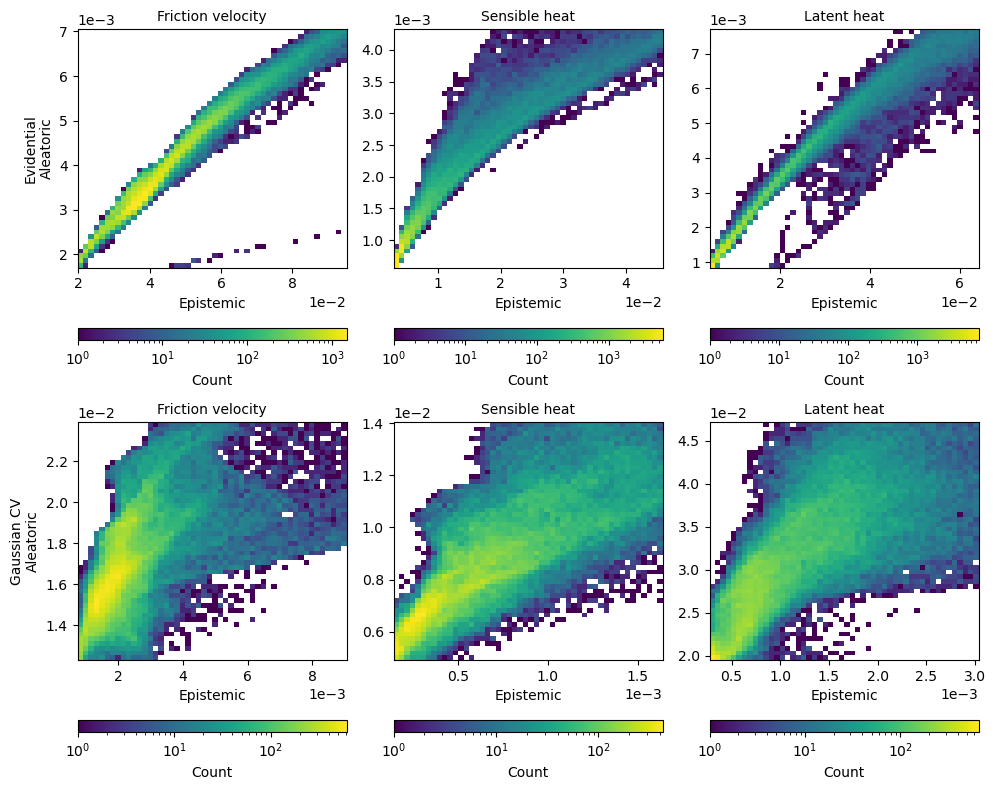

In [39]:
plot_uncertainties(
    [np.sqrt(aleatoric), np.sqrt(aleatoric_cv)],
    [np.sqrt(epistemic), np.sqrt(epistemic_cv)],
    output_cols,
    legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"],
    num_bins = 50,
    save_location = "figures/"
)

In [49]:
def compute_skill_score(y_true, y_pred, y_std, num_bins=10):
    """
    Computes the skill score with RMSE on the y-axis and binned spread on the x-axis.

    Parameters
    ----------
    y_true : array-like
        A 1D array of true values.
    y_pred : array-like
        A 1D array of predicted values.
    y_std : array-like
        A 1D array of standard deviations of predicted values.
    num_bins : int, optional
        The number of bins to use for binning the spread.

    Returns
    -------
    ss : array-like
        A 2D array of skill scores.
    bins : array-like
        A 1D array of bin edges for the spread.
    """

    # Bin the spread
    spread_min, spread_max = np.percentile(y_std, [5, 95])
    if spread_max - spread_min > 20:
        bins = np.geomspace(spread_min, spread_max, num_bins + 1)
    else:
        bins = np.linspace(spread_min, spread_max, num_bins + 1)
    digitized = np.digitize(y_std, bins)

    # Compute the mean RMSE for each bin
    ss = np.zeros((num_bins,))
    count = np.zeros((num_bins,))
    for i in range(num_bins):
        idx = np.where(digitized == i + 1)[0]
        if len(idx) > 0:
            ss[i] = np.sqrt(np.mean((y_true[idx] - y_pred[idx]) ** 2))
            count[i] = len(idx)
    return ss, count, bins


def plot_skill_score(
    y_true,
    y_pred,
    y_ale,
    y_epi,
    output_cols,
    num_bins=50,
    legend_cols=None,
    save_location=False,
):
    """
    Plots the skill score with RMSE on the y-axis and binned spread on the x-axis.

    Parameters
    ----------
    y_true : array-like
        A 1D array of true values.
    y_pred : array-like
        A 1D array of predicted values.
    y_std : array-like
        A 1D array of standard deviations of predicted values.
    num_bins : int, optional
        The number of bins to use for binning the spread.
    """
    num_outputs = len(output_cols)
    if num_outputs == 1:
        y_true = np.expand_dims(y_true, 1)
        y_pred = np.expand_dims(y_pred, 1)
        y_ale = np.expand_dims(y_ale, 1)
        y_epi = np.expand_dims(y_epi, 1)

    width = 9
    height = 6
    fig, axs = plt.subplots(num_outputs, 3, figsize=(width, height))
    if num_outputs == 1:
        axs = [axs]

    if legend_cols is None:
        legend_cols = output_cols

    unc_lab = [r"Aleatoric $\sigma$", r"Epistemic $\sigma$", r"Total $\sigma$"]

    for j in range(num_outputs):

        y_tot = np.sqrt(y_ale**2 + y_epi**2)

        for i, std in enumerate([y_ale, y_epi, y_tot]):

            # Compute the skill score
            not_nan = np.isfinite(y_pred[:, j]) & np.isfinite(std[:, j])
            
            ss, counts, bins = compute_skill_score(
                y_true[:, j][not_nan], y_pred[:, j][not_nan], std[:, j][not_nan], num_bins
            )

            # Compute bin centers
            x_centers = (bins[:-1] + bins[1:]) / 2
            y_centers = ss
            
            norm = LogNorm(vmin=146,vmax=50780)
            
            # Calculate range based on percentile of counts
            my_range = [
                [
                    min(np.percentile(x_centers, 0), np.percentile(y_centers, 0)),
                    np.percentile(x_centers, 100),
                ],
                [
                    min(np.percentile(x_centers, 0), np.percentile(y_centers, 0)),
                    np.percentile(y_centers, 100),
                ],
            ]
            
            _, _, _, sc = axs[j][i].hist2d(
                x_centers,
                y_centers,
                weights=counts,# / sum(counts),
                bins=num_bins,
                cmap="viridis_r",
                range=my_range,
                norm=norm
            )

            # Add 1-1 line
            minx = min(min(x_centers), min(y_centers))
            maxx = max(max(x_centers), max(y_centers))
            ranger = np.linspace(minx, maxx, 10)
            axs[j][i].plot(ranger, ranger, c="r", ls="--", lw=3, zorder=10)
            axs[j][i].set_xlim([my_range[0][0], my_range[0][1]])
            axs[j][i].set_ylim([my_range[1][0], my_range[1][1]])

            if i == 0:
                axs[j][i].set_ylabel(f"{legend_cols[j]}\nSkill (RMSE)")
            if j == num_outputs - 1:
                axs[j][i].set_xlabel(unc_lab[i])
            axs[j][i].ticklabel_format(style="sci", axis="both", scilimits=(-1, 1))
            
    cbaxes = fig.add_axes([0.125, -0.03, 0.8, 0.03])  # left, bottom, width, height]
    cbar = fig.colorbar(sc, cax=cbaxes, orientation="horizontal", pad = 0.2, norm = norm)
    cbar.set_label("Count")
    
    
    axs[0][0].text(-0.1, 1.13, "(a)(i)", transform=axs[0][0].transAxes, fontsize=10, va='top', ha='right')
    axs[1][0].text(-0.1, 1.13, "(b)(i)", transform=axs[1][0].transAxes, fontsize=10, va='top', ha='right')
    axs[2][0].text(-0.1, 1.13, "(c)(i)", transform=axs[2][0].transAxes, fontsize=10, va='top', ha='right')
    
    axs[0][1].text(-0.012, 1.13, "(a)(ii)", transform=axs[0][1].transAxes, fontsize=10, va='top', ha='right')
    axs[1][1].text(-0.012, 1.13, "(b)(ii)", transform=axs[1][1].transAxes, fontsize=10, va='top', ha='right')
    axs[2][1].text(-0.012, 1.13, "(c)(ii)", transform=axs[2][1].transAxes, fontsize=10, va='top', ha='right')
    
    axs[0][2].text(-0.012, 1.13, "(a)(iii)", transform=axs[0][2].transAxes, fontsize=10, va='top', ha='right')
    axs[1][2].text(-0.012, 1.13, "(b)(iii)", transform=axs[1][2].transAxes, fontsize=10, va='top', ha='right')
    axs[2][2].text(-0.012, 1.13, "(c)(iii)", transform=axs[2][2].transAxes, fontsize=10, va='top', ha='right')
        

    plt.tight_layout()
    
    if save_location:
        plt.savefig(
            save_location,
            dpi=300,
            bbox_inches="tight",
        )

/glade/derecho/scratch/dgagne/tmp/ipykernel_211330/959580216.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


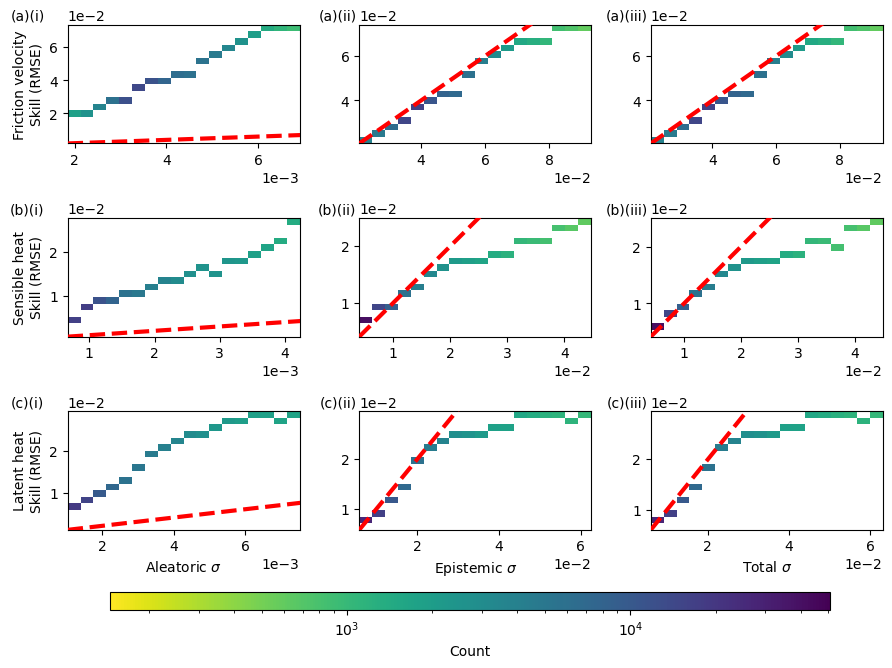

In [53]:
plot_skill_score(
    df[output_cols].values,
    mu,
    np.sqrt(aleatoric),
    np.sqrt(epistemic),
    output_cols,
    legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"],
    num_bins=18,
    save_location="figures/figure12.pdf",
)

/glade/derecho/scratch/dgagne/tmp/ipykernel_211330/959580216.py:158: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


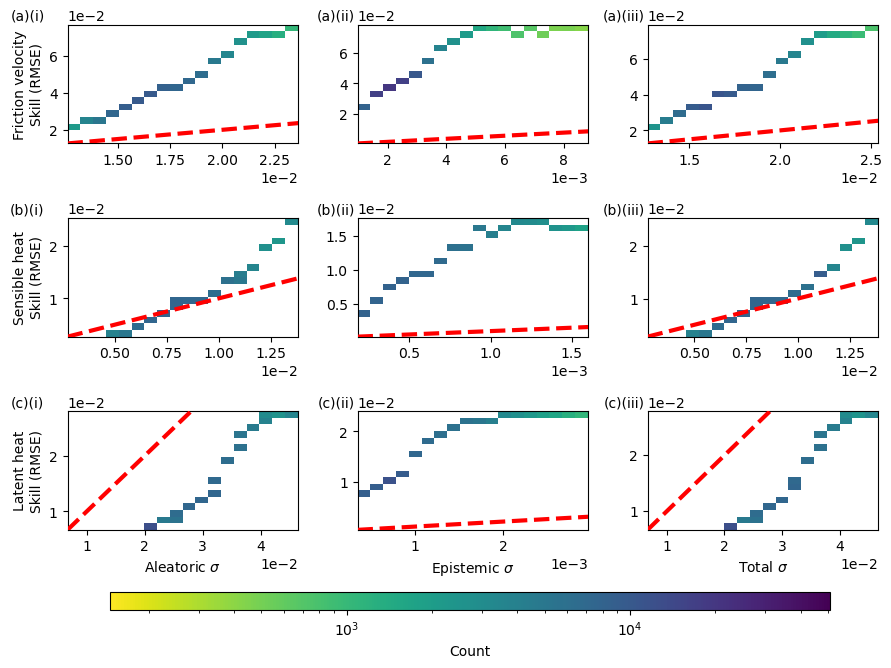

In [52]:
plot_skill_score(
    df_cv[output_cols].values,
    mu_cv,
    np.sqrt(aleatoric_cv),
    np.sqrt(epistemic_cv),
    output_cols,
    legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"],
    num_bins=18,
    save_location="figures/figure12b.pdf",
)

In [63]:


def plot_spread_skill(
    y_true,
    y_preds,
    y_ales,
    y_epis,
    output_cols,
    model_names,
    model_cmaps,
    num_bins=50,
    legend_cols=None,
    save_location=False,
):
    """
    Plots the skill score with RMSE on the y-axis and binned spread on the x-axis.

    Parameters
    ----------
    y_true : array-like
        A 1D array of true values.
    y_pred : array-like
        A 1D array of predicted values.
    y_std : array-like
        A 1D array of standard deviations of predicted values.
    num_bins : int, optional
        The number of bins to use for binning the spread.
    """
    num_outputs = len(output_cols)
    num_models = len(y_preds)
    width = 9
    height = 6
    fig, axs = plt.subplots(num_outputs, 3, figsize=(width, height))
    if num_outputs == 1:
        axs = [axs]

    if legend_cols is None:
        legend_cols = output_cols

    unc_lab = [r"Aleatoric $\sigma$", r"Epistemic $\sigma$", r"Total $\sigma$"]
    scs = []
    for j in range(num_outputs):
        for m in range(num_models):
            y_tot = np.sqrt(y_ales[m] ** 2 + y_epis[m] ** 2)
            y_pred = y_preds[m]
            y_ale = y_ales[m]
            y_epi = y_epis[m]
            for i, std in enumerate([y_ale, y_epi, y_tot]):
    
                # Compute the skill score
                not_nan = np.isfinite(y_pred[:, j]) & np.isfinite(std[:, j])
                
                ss, counts, bins = compute_skill_score(
                    y_true[:, j][not_nan], y_pred[:, j][not_nan], std[:, j][not_nan], num_bins
                )
    
                # Compute bin centers
                x_centers = (bins[:-1] + bins[1:]) / 2
                #x_centers = bins
                y_centers = ss
                
                norm = LogNorm(vmin=146, vmax=50780)
                
                # Calculate range based on percentile of counts
                my_range = [
                    [
                        min(np.percentile(x_centers, 0), np.percentile(y_centers, 0)),
                        np.percentile(x_centers, 100),
                    ],
                    [
                        min(np.percentile(x_centers, 0), np.percentile(y_centers, 0)),
                        np.percentile(y_centers, 100),
                    ],
                ]
                #print(x_centers.shape, y_centers.shape)
                _, _, _, sc = axs[j][i].hist2d(
                    x_centers,
                    y_centers,
                    weights=counts,# / sum(counts),
                    bins=num_bins,
                    cmap=model_cmaps[m],
                    range=my_range,
                   norm=norm
                )
                #sc = axs[j][i].scatter(x_centers, y_centers, 10, counts, cmap=model_cmaps[m],
                #                  norm=LogNorm(), vmin=my_range[0][0], vmax=my_range[0][1])
                axs[j][i].set_xlim(0, 0.08)
                axs[j][i].set_ylim(0, 0.08)
                axs[j][i].plot(np.linspace(0, 0.08, 10), np.linspace(0, 0.08, 10), 'k--', lw=0.5)
                if i == 0:
                    axs[j][i].set_ylabel(f"{legend_cols[j]}\nSkill (RMSE)")
                if j == num_outputs - 1:
                    axs[j][i].set_xlabel(unc_lab[i])
                axs[j][i].ticklabel_format(style="sci", axis="both", scilimits=(-1, 1))
                
            
            scs.append(sc)


            # Add 1-1 line
            minx = min(min(x_centers), min(y_centers))
            maxx = max(max(x_centers), max(y_centers))
            ranger = np.linspace(minx, maxx, 10)
            #axs[j][i].plot(ranger, ranger, c="r", ls="--", lw=3, zorder=10)
            #axs[j][i].set_xlim([my_range[0][0], my_range[0][1]])
            #axs[j][i].set_ylim([my_range[1][0], my_range[1][1]])
                   


            
            
    total_c_width = 0.8
    start_x = 0.125
    part_width = total_c_width / num_models
    for m in range(num_models):
        cbaxes = fig.add_axes([start_x + m * part_width + m * 0.01, -0.03, part_width, 0.03])  # left, bottom, width, height
        cbar = fig.colorbar(scs[m], cax=cbaxes, orientation="horizontal", pad=0.2, norm=norm)
        cbar.set_label(model_names[m])
    
    
    axs[0][0].text(-0.1, 1.16, "(a)(i)", transform=axs[0][0].transAxes, fontsize=10, va='top', ha='right')
    axs[1][0].text(-0.1, 1.16, "(b)(i)", transform=axs[1][0].transAxes, fontsize=10, va='top', ha='right')
    axs[2][0].text(-0.1, 1.16, "(c)(i)", transform=axs[2][0].transAxes, fontsize=10, va='top', ha='right')
    
    axs[0][1].text(-0.012, 1.16, "(a)(ii)", transform=axs[0][1].transAxes, fontsize=10, va='top', ha='right')
    axs[1][1].text(-0.012, 1.16, "(b)(ii)", transform=axs[1][1].transAxes, fontsize=10, va='top', ha='right')
    axs[2][1].text(-0.012, 1.16, "(c)(ii)", transform=axs[2][1].transAxes, fontsize=10, va='top', ha='right')
    
    axs[0][2].text(-0.012, 1.16, "(a)(iii)", transform=axs[0][2].transAxes, fontsize=10, va='top', ha='right')
    axs[1][2].text(-0.012, 1.16, "(b)(iii)", transform=axs[1][2].transAxes, fontsize=10, va='top', ha='right')
    axs[2][2].text(-0.012, 1.16, "(c)(iii)", transform=axs[2][2].transAxes, fontsize=10, va='top', ha='right')
    plt.tight_layout()       
    if save_location:
        plt.savefig(
            save_location,
            dpi=300,
            bbox_inches="tight",
        )

/glade/derecho/scratch/dgagne/tmp/ipykernel_211330/2103321459.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


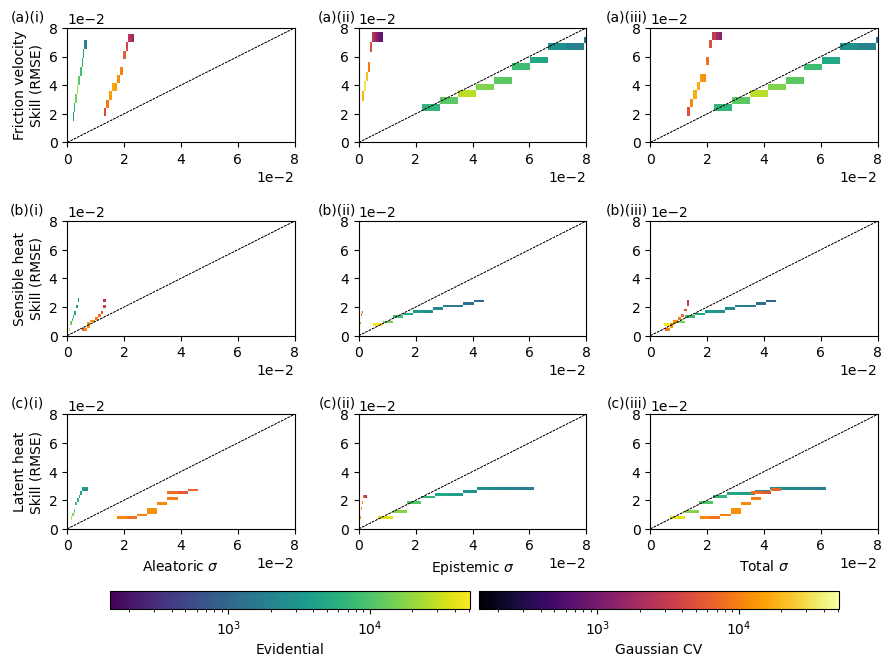

In [64]:
plot_spread_skill(df_cv[output_cols].values,
    [mu, mu_cv],
    [np.sqrt(aleatoric), np.sqrt(aleatoric_cv)],
    [np.sqrt(epistemic), np.sqrt(epistemic_cv)],
    output_cols,
    ["Evidential", "Gaussian CV"],
    ["viridis", "inferno"], 
    legend_cols =["Friction velocity", "Sensible heat", "Latent heat"],
    num_bins=11,
    save_location="figures/figure9_new.pdf",
)

In [51]:
sl_true = df_cv[output_cols].values
o_cols = ["Friction velocity", "Sensible heat", "Latent heat"]
print("Evidential")
for o in range(sl_true.shape[1]):
    score = r2_score(sl_true[:, o], mu[:, o])
    print(o_cols[o], score)
print("Gaussian CV")
for o in range(sl_true.shape[1]):
    score = r2_score(sl_true[:, o], mu_cv[:, o])
    print(o_cols[o], score)

Evidential
Friction velocity 0.9178957236196126
Sensible heat 0.8151786552878536
Latent heat 0.7675352323315368
Gaussian CV
Friction velocity 0.9164265617211078
Sensible heat 0.8152712454730708
Latent heat 0.7554035081106649


In [100]:
df_lh_cv["kinematic_latent_heat_flux:surface:g_kg-1_m_s-1"]

0       -0.006330
1       -0.005414
2       -0.002791
3       -0.001181
4       -0.000422
           ...   
72284   -0.011716
72285   -0.010880
72286   -0.010088
72287   -0.009797
72288   -0.009387
Name: kinematic_latent_heat_flux:surface:g_kg-1_m_s-1, Length: 72289, dtype: float64

In [20]:
from sklearn.metrics import r2_score

def rmse_crps_skill_scores(y_true, y_pred, aleatoric, epistemic):
    # Initialize dictionaries to store r2_rmse and r2_crps for each column
    r2_rmse_dict = {}
    r2_crps_dict = {}

    # Get the number of columns from y_pred
    num_cols = y_pred.shape[1]

    # Loop over the columns
    for col in range(num_cols):
        result = calculate_skill_score(
            y_true[:, col],  # Use y_true for the true values
            y_pred[:, col],  # Use y_pred for the predicted values
            np.sqrt(aleatoric[:, col] + epistemic[:, col]),
            num_bins=100,
            log=True
        )
        r2_rmse = r2_score(result['bin'], result['rmse'])
        r2_crps = r2_score(result['bin'], result['crps'])
        r2_rmse_dict[col] = r2_rmse
        r2_crps_dict[col] = r2_crps
        
        if np.isnan(r2_rmse):
            r2_rmse = -10
        
        # Check if r2_crps is NaN and replace it with -10
        if np.isnan(r2_crps):
            r2_crps = -10

    # Calculate the average of r2_rmse and r2_crps
    avg_r2_rmse = sum(r2_rmse_dict.values()) / num_cols
    avg_r2_crps = sum(r2_crps_dict.values()) / num_cols

    # Create and return a dictionary with average r2_rmse and r2_crps
    avg_scores_dict = {'r2_rmse': avg_r2_rmse, 'r2_crps': avg_r2_crps}
    return avg_scores_dict


In [21]:
r2_scores = rmse_crps_skill_scores(df[output_cols].values, mu, aleatoric, epistemic)
print(r2_scores)

{'r2_rmse': 0.7517720595000549, 'r2_crps': 0.05323600542184984}


### Attributes again so we have a common axis range

In [22]:
def regression_attributes(df, output_cols, legend_cols, nbins=11, save_location=False, fontsize=10):
    width = 7 if len(output_cols) == 1 else 10
    height = 3.5
    fig, axs = plt.subplots(1, len(output_cols), figsize=(width, height))

    if len(output_cols) == 1:
        axs = [axs]

    for k, col in enumerate(output_cols):
        upper = 1.01 * max(df[f"{col}_pred"])
        lower = 0.99 * min(df[f"{col}_pred"])
        bins = np.linspace(lower, upper, nbins)
        bin_range = np.digitize(df[f"{col}_pred"].values, bins=bins)
        bin_means = [
            df[f"{col}_pred"][bin_range == i].mean() for i in range(1, len(bins))
        ]
        histogram = defaultdict(list)
        for bin_no in range(1, max(list(set(bin_range)))):
            idx = np.where(bin_range == bin_no)
            residuals = df[f"{col}"].values[idx]
            mean = np.mean(residuals)
            std = np.std(residuals)
            if np.isfinite(mean):
                histogram["bin"].append(bin_means[bin_no - 1])
                histogram["mean"].append(mean)
                histogram["std"].append(std)
        axs[k].errorbar(
            histogram["bin"], histogram["mean"], yerr=histogram["std"], c="r", zorder=2
        )
        # axs[k].plot(histogram["bin"], histogram["mean"], c = "r")
        axs[k].plot(histogram["bin"], histogram["bin"], "k--")

        # curve for the no-skill line
        ave_true = np.mean(histogram["mean"])
        ave_true_range = np.array([ave_true for x in histogram["mean"]])
        no_skill = [0.5 * x1 + 0.5 * ave_true for x1 in histogram["bin"]]
        axs[k].plot(histogram["bin"], no_skill, "b-")
        axs[k].plot(histogram["bin"], ave_true_range, ls=":", color="lightgrey")
        axs[k].plot(ave_true_range, histogram["mean"], ls=":", color="lightgrey")

        full_range = np.linspace(min(histogram["bin"]), max(histogram["bin"]), 200)
        no_skill = [0.5 * x1 + 0.5 * ave_true for x1 in full_range]
        fill_cond = np.where(full_range < ave_true)[0]
        axs[k].fill_between(
            np.array(full_range)[fill_cond],
            min(
                min(np.array(histogram["mean"]) - np.array(histogram["std"])),
                min(np.array(full_range)),
            ),
            np.array(no_skill)[fill_cond],
            color="lightblue",
        )
        fill_cond = np.where(full_range > ave_true)[0]
        axs[k].fill_between(
            np.array(full_range)[fill_cond],
            max(
                max(np.array(histogram["mean"]) + np.array(histogram["std"])),
                max(np.array(full_range)),
            ),
            np.array(no_skill)[fill_cond],
            color="lightblue",
        )

        axs[k].set_title(f"{legend_cols[k]}", fontsize=fontsize)
        axs[k].set_ylabel("Conditional mean observation")
        axs[k].set_xlabel("Prediction")

    plt.tight_layout()
    # if save_location:
    #     plt.savefig(
    #         os.path.join(save_location, "regression_attributes.png"),
    #         dpi=300,
    #         bbox_inches="tight",
    #     )

In [23]:
mu_cols = [f"{x}_pred" for x in output_cols]
err_cols = [f"{x}_err" for x in output_cols]
e_cols = [f"{x}_e" for x in output_cols]
a_cols = [f"{x}_a" for x in output_cols]
t_cols = [f"{x}_t" for x in output_cols]

# Add the predictions to the dataframe and compute absolute error
df[mu_cols] = mu
df[a_cols] = np.sqrt(aleatoric)
df[e_cols] = np.sqrt(epistemic)
df[t_cols] = np.sqrt(aleatoric + epistemic)
df[err_cols] = np.abs(mu - df[output_cols])
    
#regression_attributes(df, output_cols, legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"])

In [53]:
def regression_attributes(df_list, output_cols, legend_cols, nbins=11, save_location=False, fontsize=10, ranges = {}, titles = True, xlabels = True):
    num_plots = len(df_list)
    fig, axs = plt.subplots(1, num_plots, figsize=(num_plots * 3.5, 3.5))

    if num_plots == 1:
        axs = [axs]

    for i, (df, col) in enumerate(zip(df_list, output_cols)):
        if col in ranges:
            upper, lower = ranges[col]
        else:
            upper = 1.01 * max(df[f"{col}_pred"])
            lower = 0.99 * min(df[f"{col}_pred"])
        print(i, col, upper, lower)
        bins = np.linspace(lower, upper, nbins)
        bin_range = np.digitize(df[f"{col}_pred"].values, bins=bins)
        bin_means = [
            df[f"{col}_pred"][bin_range == i].mean() for i in range(1, len(bins))
        ]
        histogram = defaultdict(list)
        for bin_no in range(1, max(list(set(bin_range)))):
            idx = np.where(bin_range == bin_no)
            residuals = df[f"{col}"].values[idx]
            mean = np.mean(residuals)
            std = np.std(residuals)
            if np.isfinite(mean):
                histogram["bin"].append(bin_means[bin_no - 1])
                histogram["mean"].append(mean)
                histogram["std"].append(std)
        axs[i].errorbar(
            histogram["bin"], histogram["mean"], yerr=histogram["std"], c="r", zorder=2
        )
        axs[i].plot(histogram["bin"], histogram["bin"], "k--")

        ave_true = np.mean(histogram["mean"])
        ave_true_range = np.array([ave_true for x in histogram["mean"]])
        no_skill = [0.5 * x1 + 0.5 * ave_true for x1 in histogram["bin"]]
        axs[i].plot(histogram["bin"], no_skill, "b-")
        axs[i].plot(histogram["bin"], ave_true_range, ls=":", color="lightgrey")
        axs[i].plot(ave_true_range, histogram["mean"], ls=":", color="lightgrey")

        full_range = np.linspace(min(histogram["bin"]), max(histogram["bin"]), 200)
        no_skill = [0.5 * x1 + 0.5 * ave_true for x1 in full_range]
        fill_cond = np.where(full_range < ave_true)[0]
        axs[i].fill_between(
            np.array(full_range)[fill_cond],
            min(
                min(np.array(histogram["mean"]) - np.array(histogram["std"])),
                min(np.array(full_range)),
            ),
            np.array(no_skill)[fill_cond],
            color="lightblue",
        )
        fill_cond = np.where(full_range > ave_true)[0]
        axs[i].fill_between(
            np.array(full_range)[fill_cond],
            max(
                max(np.array(histogram["mean"]) + np.array(histogram["std"])),
                max(np.array(full_range)),
            ),
            np.array(no_skill)[fill_cond],
            color="lightblue",
        )
        if titles:
            axs[i].set_title(f"{legend_cols[i]}", fontsize=fontsize)
        if i == 0:
            axs[i].set_ylabel("Conditional mean observation")
        if xlabels:
            axs[i].set_xlabel("Prediction")

    plt.tight_layout()
    # if save_location:
    #     plt.savefig(
    #         os.path.join(save_location, "regression_attributes.png"),
    #         dpi=300,
    #         bbox_inches="tight",
    #     )


In [64]:
# ranges = {
#     'friction_velocity:surface:m_s-1': [0.01722320876643058, 1.0205197758078577],
#     'kinematic_sensible_heat_flux:surface:K_m_s-1': [-0.05496141618, 0.20751575139999998],
#     'kinematic_latent_heat_flux:surface:g_kg-1_m_s-1': [-0.01671759810950605, 0.16933884340524671]
# }

0 friction_velocity:surface:m_s-1 0.944624922 0.0192110094
1 kinematic_sensible_heat_flux:surface:K_m_s-1 0.20751575139999998 -0.05496141618
2 kinematic_latent_heat_flux:surface:g_kg-1_m_s-1 0.15223962300000002 -0.01592920098


/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/glade/work/schreck/miniconda3/envs/evidential/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  

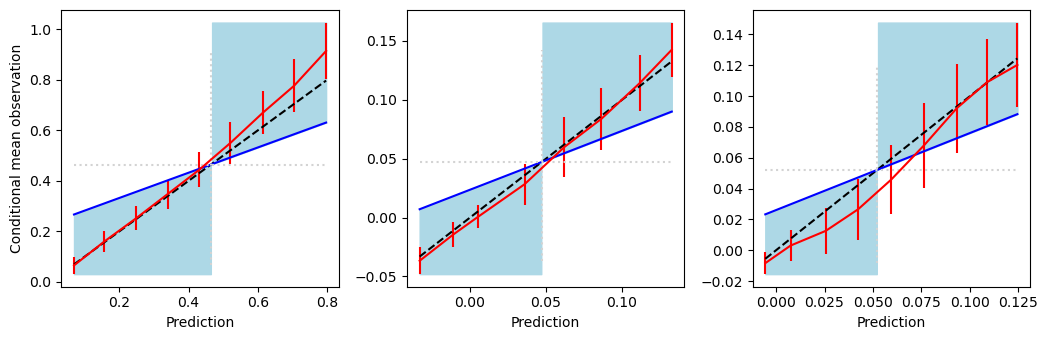

In [54]:
regression_attributes([f_fv, f_sh, f_lh], 
                      output_cols, 
                      legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"], 
                      nbins = 11, titles = False)

0 friction_velocity:surface:m_s-1 1.020962735503912 0.017219580936245524
1 kinematic_sensible_heat_flux:surface:K_m_s-1 0.20420102606713772 -0.0464219957068562
2 kinematic_latent_heat_flux:surface:g_kg-1_m_s-1 0.1829045988544821 -0.016875021893531076


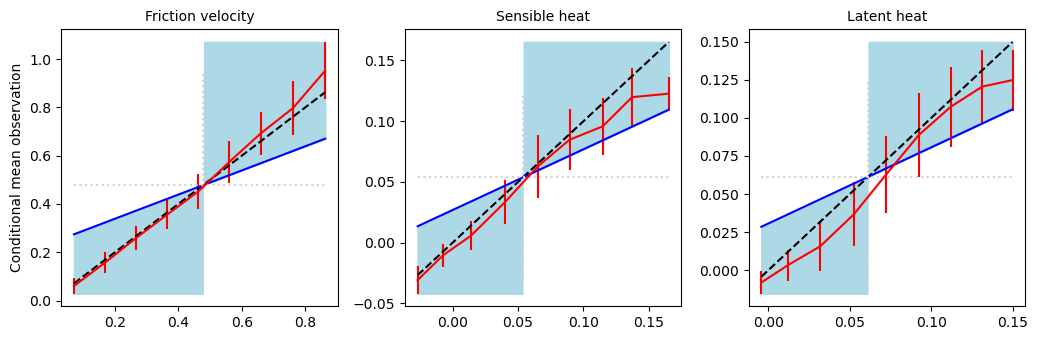

In [55]:
regression_attributes([df_fv_cv, df_sh_cv, df_lh_cv], 
                      output_cols, 
                      legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"], 
                      nbins = 11, xlabels = False)

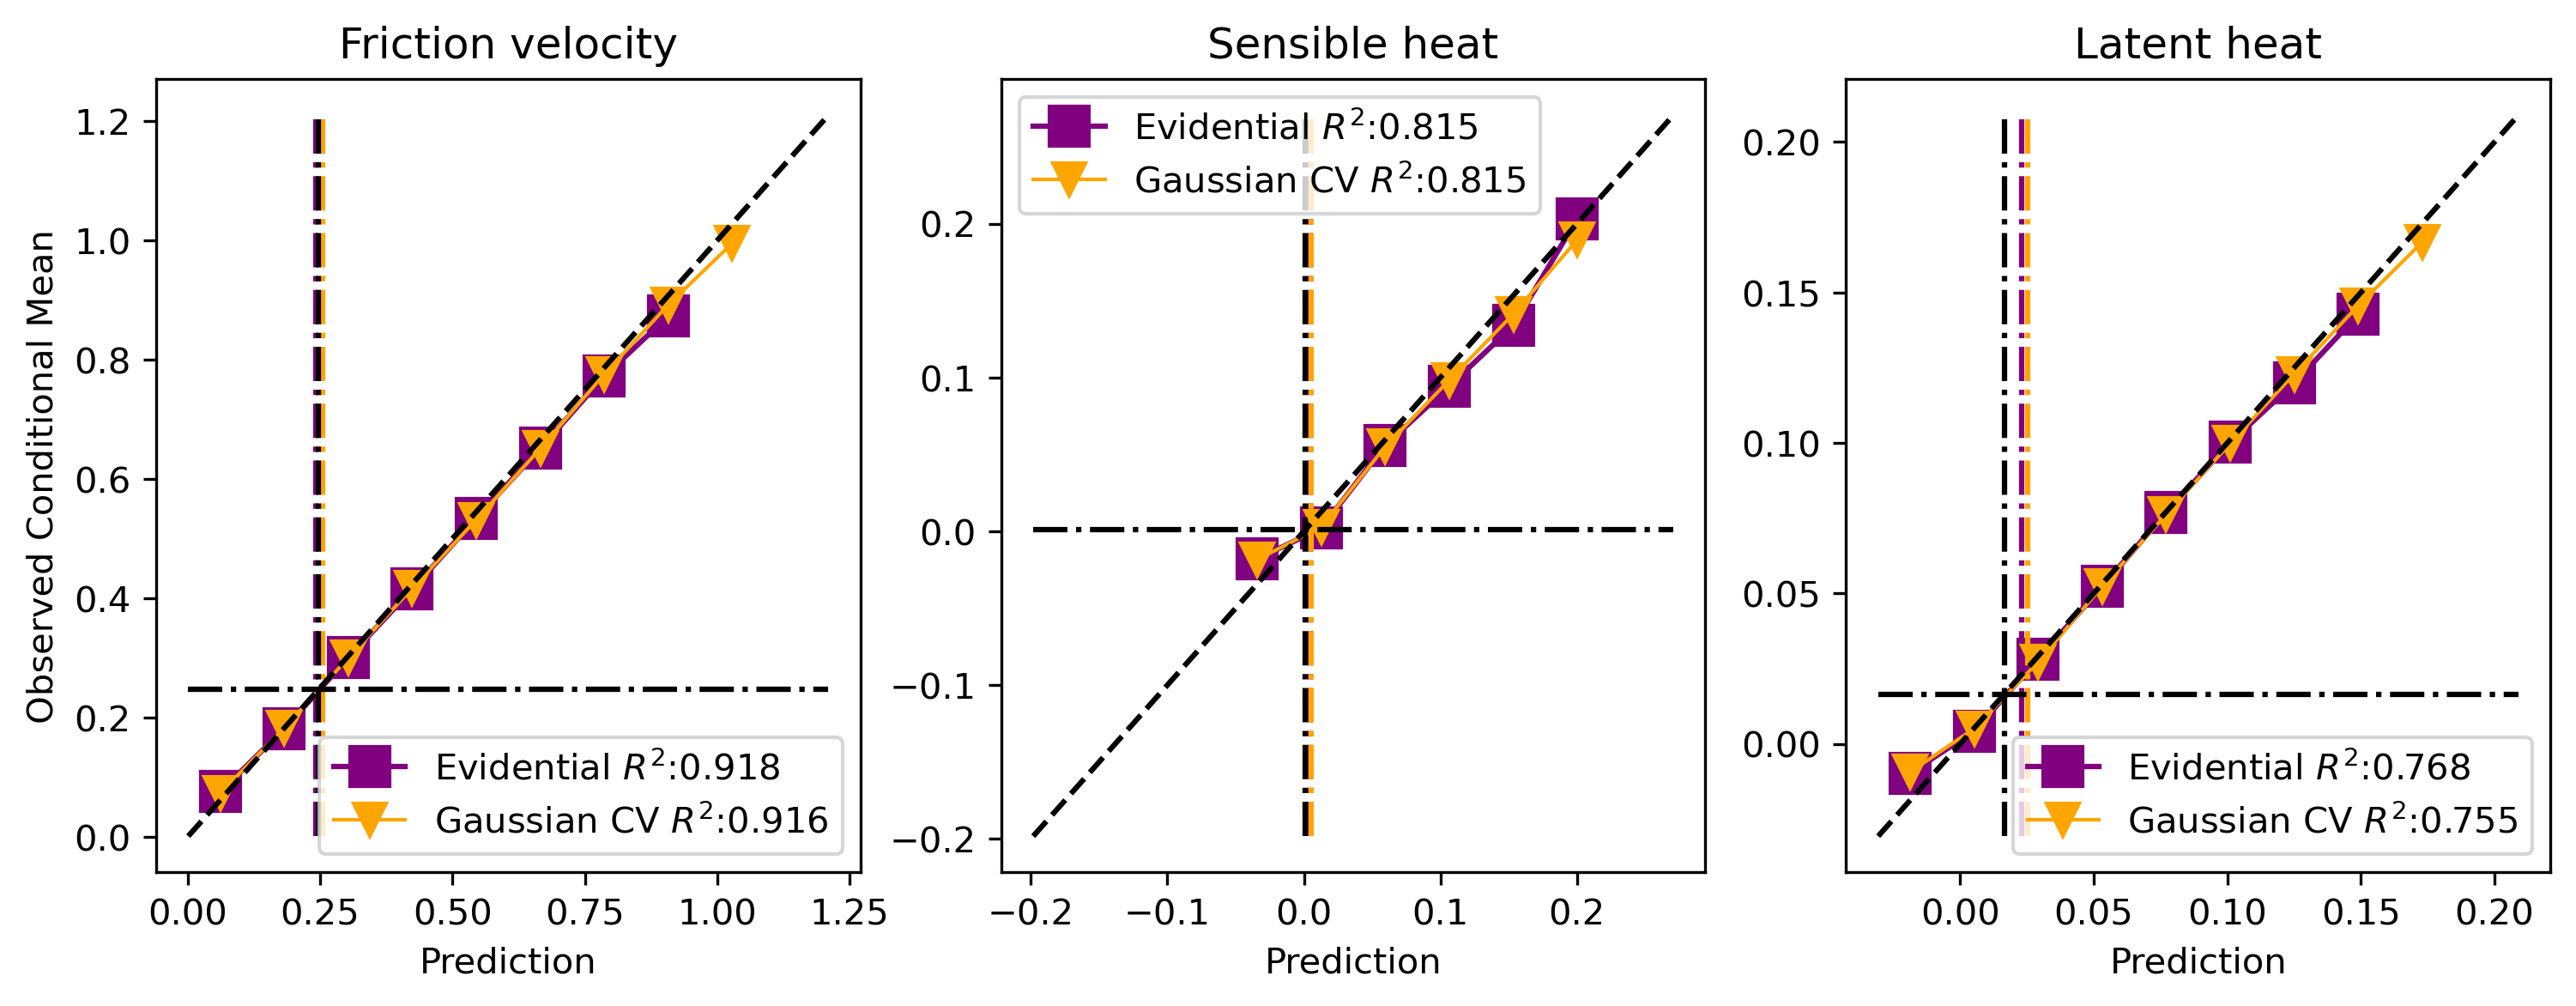

In [18]:
bins = 11
colors = ["purple", "orange"]
markers = ["s", "v"]
lws = [1.5, 1]
m_sizes = [11, 9]
models = ["Evidential", "Gaussian CV"]
title_cols = ["Friction velocity", "Sensible heat", "Latent heat"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
for o, output_col in enumerate(output_cols):
    bin_edges = np.linspace(df[output_col].min(), df[output_col].max(), bins)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    rel_vals = {}
    for m, mod_df in enumerate([df, df_cv]):
        rel_curve = np.zeros(len(bin_centers))
        preds = mod_df[output_col + "_pred"]
        for b, be in enumerate(bin_edges[:-1]):
            rel_curve[b] = preds[(preds >= be) & (preds <=bin_edges[b + 1])].mean()
        score = r2_score(df[output_col], preds)
        axes[o].plot(bin_centers, rel_curve, color=colors[m], 
                     marker=markers[m], ms=m_sizes[m], label=models[m] + f" $R^2$:{score:0.3f}", lw=lws[m])
        axes[o].plot(np.ones_like(bin_edges) * preds.mean(), bin_edges,  ls='-.', color=colors[m])

    axes[o].plot(bin_edges, bin_edges, 'k--')
    axes[o].plot(bin_edges, np.ones_like(bin_edges) * df[output_col].mean(), 'k-.')
    axes[o].plot(np.ones_like(bin_edges) * df[output_col].mean(), bin_edges,  'k-.')

    axes[o].set_title(title_cols[o])
    axes[o].set_xlabel("Prediction")
    axes[o].legend()
    if o == 0:
        axes[o].set_ylabel("Observed Conditional Mean")
plt.savefig("figures/figure_8_new.pdf", bbox_inches="tight")

### Time-dependence plots for latent heat

In [14]:
#dq = pd.read_csv(f"/glade/scratch/schreck/repos/evidential/results/surface_layer/evidential_sensible_heat/calibration/7/evaluate/test.csv")

In [13]:
condition = np.array(["2003-03-03" in x for x in dq["Time"]])

NameError: name 'dq' is not defined

In [10]:
gamma = dq[condition]["kinematic_sensible_heat_flux:surface:K_m_s-1"]
gamma_pred = dq[condition]["kinematic_sensible_heat_flux:surface:K_m_s-1_pred"]
_ale = np.sqrt(dq[condition]["kinematic_sensible_heat_flux:surface:K_m_s-1_ale"])
_epi = np.sqrt(dq[condition]["kinematic_sensible_heat_flux:surface:K_m_s-1_epi"])

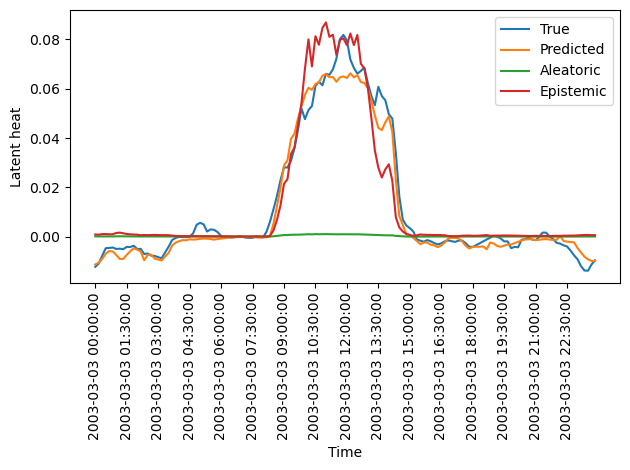

In [11]:
plt.plot(dq[condition]["Time"], gamma)
plt.plot(dq[condition]["Time"], gamma_pred)
plt.plot(dq[condition]["Time"], _ale)
plt.plot(dq[condition]["Time"], _epi)

# Set the number of desired x-ticks
num_ticks = 15  # Specify the desired number of ticks

# Get the x-axis limits
_ = plt.xticks(ticks=plt.xticks()[0][::int(len(plt.xticks()[0]) / num_ticks)])
_ = plt.xticks(rotation = 90, fontsize = 10,  ha='center')
plt.legend(["True", "Predicted", "Aleatoric", "Epistemic"])
plt.ylabel("Latent heat")
plt.xlabel("Time")
plt.tight_layout()

In [13]:
dq["time_of_day"] = [x.split(" ")[1] for x in dq["Time"]]
dqq = dq.groupby("time_of_day").median()

/glade/scratch/schreck/ipykernel_32822/3502784683.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dqq = dq.groupby("time_of_day").median()


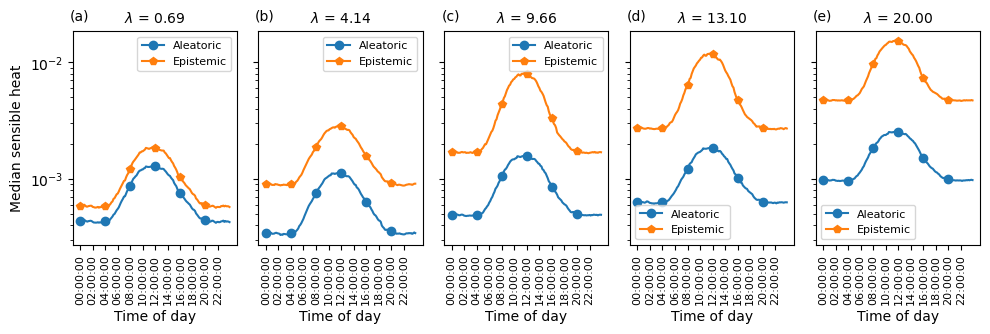

In [31]:
col = output_cols[1]
# Set the number of desired x-ticks
num_ticks = 12  # Specify the desired number of ticks

fig, axs = plt.subplots(1, 5, figsize=(10, 3.5), sharex=True,sharey=True)
titles = ["Sensible heat"]
symbols = ["^", "s", "o", "p"]

selected = [1, 6, 14, 19, 29]
orig_coeffs = np.linspace(0, 20, 30)
weights = [orig_coeffs[k] for k in selected] #[0.69, 2.75, 4.83, 6.90, 7.59]

for k, x in enumerate(selected): # [1, 4, 7, 10, 11]

    dq = pd.read_csv(f'/glade/work/schreck/repos/miles-guess/apr24/results/sensible_heat_evidential/cal/{x}/evaluate/test.csv')
    #dq = pd.read_csv(f"/glade/scratch/schreck/repos/evidential/results/surface_layer/evidential_sensible_heat/calibration/{x}/evaluate/test.csv")
    dq["time_of_day"] = [x.split(" ")[1] for x in dq["Time"]]
    selected_cols = [x for x in dq.columns if any([o in x for o in output_cols])] + ["time_of_day"]
    dqq = dq[selected_cols].groupby("time_of_day").median()

    gamma = dqq[col]
    gamma_pred = dqq[f"{col}_pred"]
    _ale = np.sqrt(dqq[f"{col}_ale"])
    _epi = np.sqrt(dqq[f"{col}_epi"])

    #axs[k].plot(dqq.index, gamma, label="True", marker = symbols[0], markevery = 24)
    #axs[k].plot(dqq.index, gamma_pred, label="Predicted", marker = symbols[1], markevery = 24)
    axs[k].plot(dqq.index, _ale, label="Aleatoric", marker = symbols[2], markevery = 24)
    axs[k].plot(dqq.index, _epi, label="Epistemic", marker = symbols[3], markevery = 24)

    # Set the x-ticks
    x_ticks = axs[k].get_xticks()
    x_ticks_subset = x_ticks[::int(len(x_ticks) / num_ticks)]
    axs[k].set_xticks(x_ticks_subset)
    axs[k].tick_params(axis='x', rotation=90, labelsize=8)

    axs[k].legend(fontsize=8)
    if k == 0:
        axs[k].set_ylabel(f"Median sensible heat", fontsize=10)
    axs[k].set_title(r"$\lambda$ = "f"{weights[k]:.2f}", fontsize=10)
    axs[k].set_xlabel("Time of day", fontsize=10)
    #axs[k].set_title(titles[k], fontsize=10)

    
    axs[k].set_yscale("log")
    
axs[0].text(0.1, 1.1, "(a)", transform=axs[0].transAxes, fontsize=10, va='top', ha='right')
axs[1].text(0.1, 1.1, "(b)", transform=axs[1].transAxes, fontsize=10, va='top', ha='right')
axs[2].text(0.1, 1.1, "(c)", transform=axs[2].transAxes, fontsize=10, va='top', ha='right')
axs[3].text(0.1, 1.1, "(d)", transform=axs[3].transAxes, fontsize=10, va='top', ha='right')
axs[4].text(0.1, 1.1, "(e)", transform=axs[4].transAxes, fontsize=10, va='top', ha='right')

plt.tight_layout()
#plt.show()

plt.savefig('figures/figureS9.pdf', dpi=300, bbox_inches='tight')

### Make figure showing the three quantities together

In [17]:
df["time_of_day"] = [x.split(" ")[1] for x in df["Time"]]

In [18]:
selected_cols = [x for x in df.columns if any([o in x for o in output_cols])] + ["time_of_day"]

In [19]:
dg = df[selected_cols].groupby("time_of_day").mean()

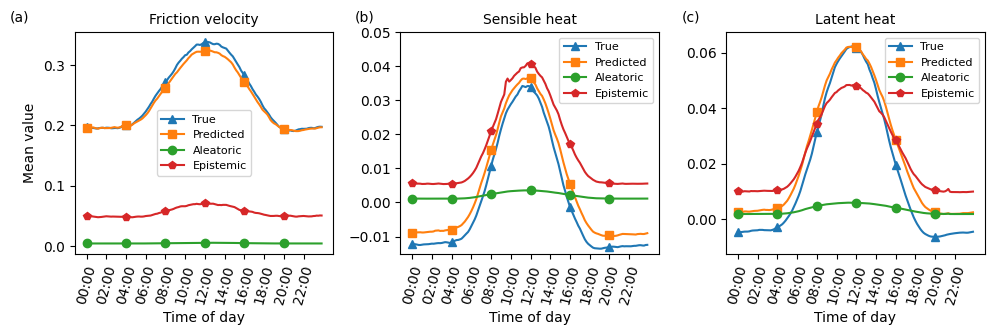

In [22]:
# Set the number of desired x-ticks
num_ticks = 12  # Specify the desired number of ticks

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))
titles = ["Friction velocity", "Sensible heat", "Latent heat"]
symbols = ["^", "s", "o", "p"]

for k, col in enumerate(output_cols):

    gamma = dg[col]
    gamma_pred = dg[f"{col}_pred"]
    _ale = np.sqrt(dg[f"{col}_ale"])
    _epi = np.sqrt(dg[f"{col}_epi"])
    xvals = [x[:5] for x in list(dg.index)]

    axs[k].plot(xvals, gamma, label="True", marker = symbols[0], markevery = 24)
    axs[k].plot(xvals, gamma_pred, label="Predicted", marker = symbols[1], markevery = 24)
    axs[k].plot(xvals, _ale, label="Aleatoric", marker = symbols[2], markevery = 24)
    axs[k].plot(xvals, _epi, label="Epistemic", marker = symbols[3], markevery = 24)

    # Set the x-ticks
    x_ticks = axs[k].get_xticks()
    x_ticks_subset = x_ticks[::int(len(x_ticks) / num_ticks)]
    axs[k].set_xticks(x_ticks_subset)
    axs[k].tick_params(axis='x', rotation=75, labelsize=10)

    axs[k].legend(fontsize=8)
    if k == 0:
        axs[k].set_ylabel(f"Mean value", fontsize=10)
    axs[k].set_title(f"{titles[k]}", fontsize=10)
    axs[k].set_xlabel("Time of day", fontsize=10)
    #axs[k].set_title(titles[k], fontsize=10)
    
    if k == 1:
        axs[k].set_ylim([-0.015, 0.05])
    if k == 2:
        axs[k].set_ylim([-0.0125, 0.0675])
    
axs[0].text(-0.175, 1.1, "(a)", transform=axs[0].transAxes, fontsize=10, va='top', ha='right')
axs[1].text(-0.1, 1.1, "(b)", transform=axs[1].transAxes, fontsize=10, va='top', ha='right')
axs[2].text(-0.1, 1.1, "(c)", transform=axs[2].transAxes, fontsize=10, va='top', ha='right')


plt.tight_layout()
#plt.show()

plt.savefig('figures/figure14.pdf', dpi=300, bbox_inches='tight')

### Custom figures for the paper

In [129]:
def discard_fraction(dfs, output_cols, legend_cols, save_location=False, fontsize=10):
    width = 7 if len(output_cols) == 1 else 10
    height = 3.5
    fig, axs = plt.subplots(1, len(output_cols), figsize=(width, height))
    if len(output_cols) == 1:
        axs = [axs]
    colors = ["#f8d605", "#ce4912", "#042c71"]

    _dfs = []
    for k, col in enumerate(output_cols):
        df = dfs[k].copy()
        df = compute_coverage(df, col=f"{col}_e", quan=f"{col}_err")
        df = compute_coverage(df, col=f"{col}_a", quan=f"{col}_err")
        # df[f"{col}_t"] = np.sqrt(df[f"{col}_a"] + df[f"{col}_e"])
        df = compute_coverage(df, col=f"{col}_t", quan=f"{col}_err")
        _dfs.append(df)
    
    for k, col in enumerate(output_cols):
        results = defaultdict(list)
        df = _dfs[k]
        for percent in range(5, 105, 5):
            c = df[f"{col}_e_cov"] >= percent / 100.0
            results["rmse_e"].append(np.square(df[c][f"{col}_err"]).mean() ** (1 / 2))
            c = df[f"{col}_a_cov"] >= percent / 100.0
            results["rmse_a"].append(np.square(df[c][f"{col}_err"]).mean() ** (1 / 2))
            c = df[f"{col}_t_cov"] >= percent / 100.0
            results["rmse_t"].append(np.square(df[c][f"{col}_err"]).mean() ** (1 / 2))
            results["frac"].append(percent)

        db = (1.0 / 3.0) * 5
        axs[k].bar(results["frac"], results["rmse_e"], db, color=colors[0])
        axs[k].bar(
            [x + db for x in results["frac"]], results["rmse_a"], db, color=colors[1]
        )
        axs[k].bar(
            [x + 2 * db for x in results["frac"]],
            results["rmse_t"],
            db,
            color=colors[2],
        )
        axs[k].set_xlabel("Fraction removed")
        axs[k].set_title(legend_cols[k], fontsize=fontsize)
        axs[k].legend(["Epistemic", "Aleatoric", "Total"], loc="best")

    axs[0].set_ylabel("RMSE")
    plt.tight_layout()

    if save_location:
        plt.savefig(
            os.path.join(save_location, "discard_fraction.png"),
            dpi=300,
            bbox_inches="tight",
        )


from mlguess.pit import pit_histogram
def pit_figure_gaussian(
    df,
    output_cols,
    titles=["Aleatoric", "Epistemic", "Total"],
    legend_cols=["Friction velocity", "Sensible heat", "Latent heat"],
    save_location=None,
):
    # Create the figure and subplot
    fig, axs = plt.subplots(1, 3, figsize=(10, 3.5), sharey="col")

    for j, uq in enumerate(["ale", "epi", "total"]):  # Index for uncertainty types
        for i, (col, df_cv) in enumerate(zip(output_cols, df)):
            # Compute uncertainties for the current dataframe
            mu = df_cv[f"{col}_pred"].values
            if uq == "total":
                uncertainty = df_cv[f"{col}_epi"].values + df_cv[f"{col}_ale"].values 
            else:
                uncertainty = df_cv[f"{col}_{uq}"].values

            bin_counts, bin_edges = pit_histogram(
                df_cv[col].values,
                np.stack([mu, np.sqrt(uncertainty)], -1),
                pred_type="gaussian",
                bins=np.linspace(0, 1, 10),
            )
            bin_width = bin_edges[1] - bin_edges[0]

            # Normalize the bin heights
            bin_heights = bin_counts / bin_width
            bin_heights /= sum(bin_heights)

            # Plot the histogram
            axs[j].bar(
                bin_edges[:-1] + i * (bin_width / len(output_cols)),
                bin_heights,
                width=bin_width / len(output_cols),
                align="edge",
                edgecolor="black",
                linewidth=1.2,
                alpha=0.7,
                label="{}".format(col),
            )

        # Add axis labels and title
        axs[j].set_xlabel("PIT Quantiles", fontsize=10)
        # axs[j].set_ylabel('Normalized Bin Height', fontsize=14)

        # Add a grid
        axs[j].grid(axis="y", linestyle="--", alpha=0.7)

        # Increase the font size of the tick labels
        axs[j].tick_params(axis="both", which="major", labelsize=10)

        # Add a legend
        if j == 0:  # Only add legend for the first subplot
            axs[j].legend(legend_cols, fontsize=8, loc="best")

        # Set the titles
        axs[j].set_title(titles[j], fontsize=10)

    plt.tight_layout()
    if save_location:
        plt.savefig(
            os.path.join(save_location, "pit_figure_gaussian.png"),
            dpi=300,
            bbox_inches="tight",
        )
    plt.show()

### PIT stacked plot for the three models 

In [147]:
# df_fv_cv = pd.read_csv(
#     "/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_friction_velocity/model/seed/evaluate/test.csv"
# )
# df_sh_cv = pd.read_csv(
#     "/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_sensible_heat/model/seed/evaluate/test.csv"
# )
# df_lh_cv = pd.read_csv(
#     "/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_latent_heat/model/seed/evaluate/test.csv"
# )

df_fv_cv = pd.read_csv(
    "/glade/work/schreck/repos/miles-guess/apr24/results/friction_velocity_gaussian/deep_ensemble/evaluate/test.csv"
    #"/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_friction_velocity/data/data/evaluate/test.csv"
)

df_sh_cv = pd.read_csv(
     "/glade/work/schreck/repos/miles-guess/apr24/results/sensible_heat_gaussian/deep_ensemble/evaluate/test.csv"
    #"/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_sensible_heat/data/data/evaluate/test.csv"
)

df_lh_cv = pd.read_csv(
    "/glade/work/schreck/repos/miles-guess/apr24/results/latent_heat_gaussian/deep_ensemble/evaluate/test.csv"
    #"/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_latent_heat/data/data/evaluate/test.csv"
)

df_cv = df_fv_cv.copy()
df_cv[[x for x in df_lh_cv.columns if x not in df_fv_cv.columns]] = df_lh_cv[[x for x in df_lh_cv.columns if x not in df_fv_cv.columns]].copy()
df_cv[[x for x in df_sh_cv.columns if x not in df_fv_cv.columns]] = df_sh_cv[[x for x in df_sh_cv.columns if x not in df_fv_cv.columns]].copy()

In [148]:
# mu = df_cv[[f'{x}_pred' for x in output_cols]].values
# aleatoric = df_cv[[f'{x}_ale' for x in output_cols]].values
# epistemic = df_cv[[f'{x}_epi' for x in output_cols]].values
# total = aleatoric + epistemic

In [139]:
# plot_uncertainties(
#     np.sqrt(aleatoric),
#     np.sqrt(epistemic),
#     output_cols,
#     legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"],
#     num_bins = 50
# )

In [105]:
# compute_results(
#     df_cv, 
#     output_cols,
#     mu, 
#     aleatoric,
#     epistemic,
#     legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"],
#     #fn = "/glade/scratch/schreck/repos/evidential/results/paper_figures/surface_layer"
# )

0 friction_velocity:surface:m_s-1 1.0217897635698319 0.016956410885788472
1 kinematic_sensible_heat_flux:surface:K_m_s-1 0.24083067092299457 -0.04582842434383921
2 kinematic_latent_heat_flux:surface:g_kg-1_m_s-1 0.182163848914206 -0.016767791099846326


/glade/u/home/schreck/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/glade/u/home/schreck/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/u/home/schreck/.local/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/u/home/schreck/.local/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/glade/u/home/schreck/.local/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


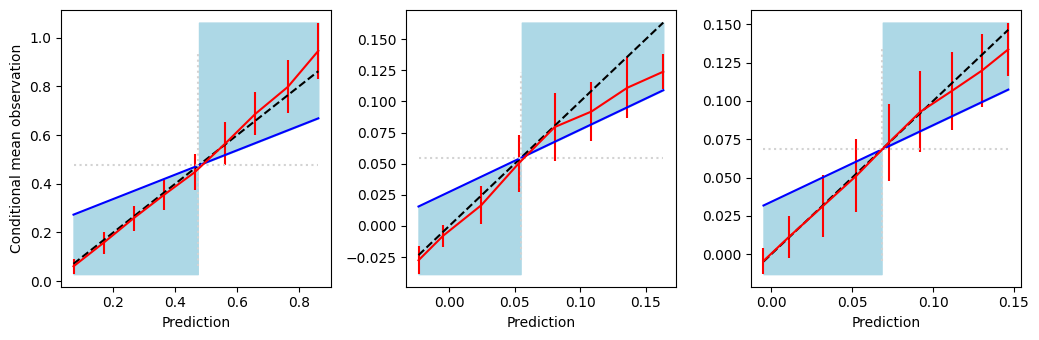

In [149]:
regression_attributes([df_fv_cv, df_sh_cv, df_lh_cv], 
                      output_cols, 
                      legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"], 
                      nbins = 11, titles = False)

In [150]:
for x, df in zip(output_cols, [df_fv_cv, df_sh_cv, df_lh_cv]):
    mu = df[f'{x}_pred'].values
    aleatoric = df[f'{x}_ale'].values
    epistemic = df[f'{x}_epi'].values
    total = aleatoric + epistemic
    df[f'{x}_a'] = aleatoric
    df[f'{x}_e'] = epistemic
    df[f'{x}_t'] = total
    df[f'{x}_err'] = np.abs(mu - df[x])

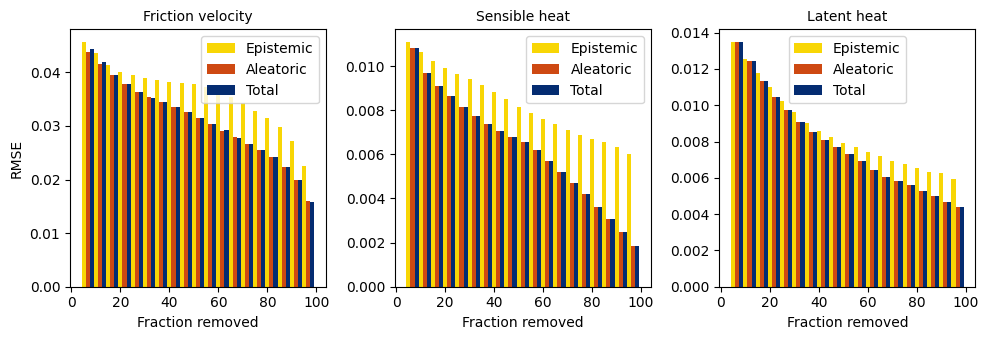

In [151]:
discard_fraction([df_fv_cv, df_sh_cv, df_lh_cv], 
                 output_cols, 
                 legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"])

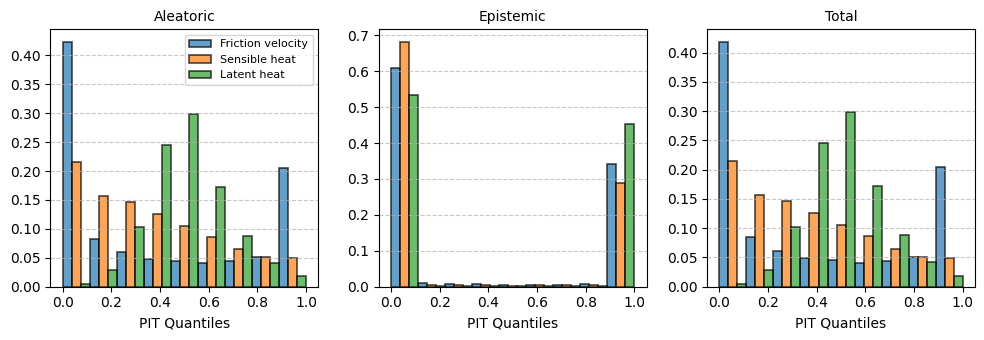

In [131]:
pit_figure_gaussian(
    [df_fv_cv, df_sh_cv, df_lh_cv],
    output_cols,
    titles=["Aleatoric", "Epistemic", "Total"],
    legend_cols=["Friction velocity", "Sensible heat", "Latent heat"],
    save_location=None
)

In [144]:
df_fv_mc = pd.read_csv(
    "/glade/work/schreck/repos/miles-guess/apr24/results/friction_velocity_gaussian/monte_carlo/evaluate/test.csv"
    #"/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_friction_velocity/data/data/evaluate/test.csv"
)

df_sh_mc = pd.read_csv(
     "/glade/work/schreck/repos/miles-guess/apr24/results/sensible_heat_gaussian/monte_carlo/evaluate/test.csv"
    #"/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_sensible_heat/data/data/evaluate/test.csv"
)

df_lh_mc = pd.read_csv(
    "/glade/work/schreck/repos/miles-guess/apr24/results/latent_heat_gaussian/monte_carlo/evaluate/test.csv"
    #"/glade/scratch/schreck/repos/evidential/results/surface_layer/gaussian_latent_heat/data/data/evaluate/test.csv"
)


In [146]:
# mu = df_mc[[f'{x}_pred' for x in output_cols]].values
# aleatoric = df_mc[[f'{x}_ale' for x in output_cols]].values
# epistemic = df_mc[[f'{x}_epi' for x in output_cols]].values
# total = aleatoric + epistemic

# compute_results(
#     df_mc, 
#     output_cols,
#     mu, 
#     aleatoric,
#     epistemic,
#     legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"],
#     #fn = "/glade/scratch/schreck/repos/evidential/results/paper_figures/surface_layer"
# )

0 friction_velocity:surface:m_s-1 1.0129116533875466 0.01706071739774193
1 kinematic_sensible_heat_flux:surface:K_m_s-1 0.23631502294391388 -0.04695690035261214
2 kinematic_latent_heat_flux:surface:g_kg-1_m_s-1 0.18084744416177265 -0.016813873127102832


/glade/u/home/schreck/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/glade/u/home/schreck/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/glade/u/home/schreck/.local/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/glade/u/home/schreck/.local/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/glade/u/home/schreck/.local/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


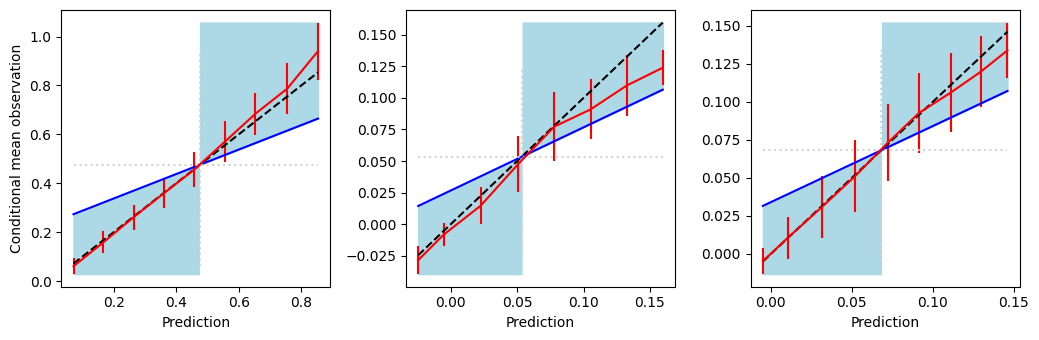

In [134]:
regression_attributes([df_fv_mc, df_sh_mc, df_lh_mc], 
                      output_cols, 
                      legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"], 
                      nbins = 11, titles = False)

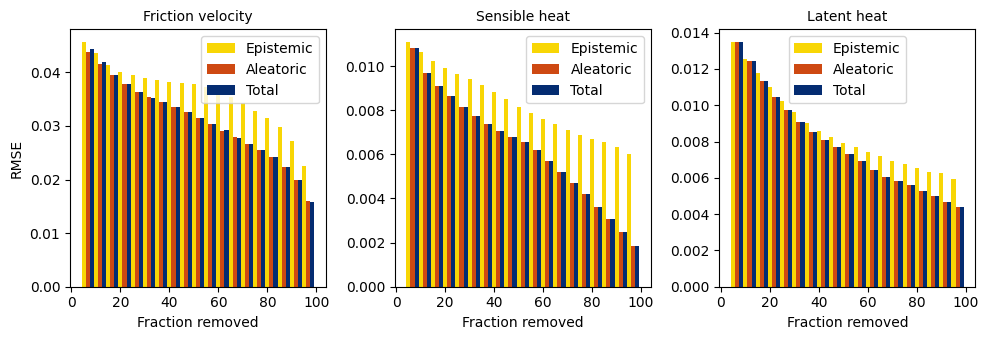

In [135]:
for x, df in zip(output_cols, [df_fv_mc, df_sh_mc, df_lh_mc]):
    mu = df[f'{x}_pred'].values
    aleatoric = df[f'{x}_ale'].values
    epistemic = df[f'{x}_epi'].values
    total = aleatoric + epistemic
    df[f'{x}_a'] = aleatoric
    df[f'{x}_e'] = epistemic
    df[f'{x}_t'] = total
    df[f'{x}_err'] = np.abs(mu - df[x])

discard_fraction([df_fv_cv, df_sh_cv, df_lh_cv], 
                 output_cols, 
                 legend_cols = ["Friction velocity", "Sensible heat", "Latent heat"])

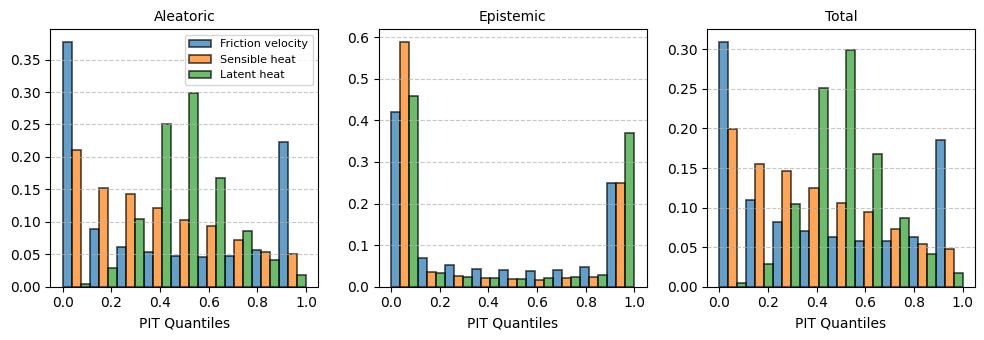

In [136]:
pit_figure_gaussian(
    [df_fv_mc, df_sh_mc, df_lh_mc],
    output_cols,
    titles=["Aleatoric", "Epistemic", "Total"],
    legend_cols=["Friction velocity", "Sensible heat", "Latent heat"],
    save_location=None
)